# COC786 - Final Project

#### Student: Vitor Mazal Krauss

This notebook is part of my final project for the class COC786 of Machine Learning at COPPE - UFRJ. 

For this project, we shall be considering the regression problem presented in [1] and [2].

We will consider the dataset originally presented in [1,2], which is available in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bias+correction+of+numerical+prediction+model+temperature+forecast).

The [Korea Meteorological Administration](https://www.kma.go.kr/eng/index.jsp) operates a weather forecast model called LDAPS.
This model provides forecasts for different weather-related measures, such as temperature, relative humidity, cloud-cover and precipitation. 
Inevitably there is bias of the LDAPS model when compared to the actual weather.
This dataset is related to the reduction of bias of the LDAPS model forecast of next-day minimum and maximum temperatures at different stations in the city of Seoul. The regression problems we consider is the prediction (and bias-reduction) of next-day maximum temperature. This prediction is to be made based on data from present-day meterological measurements and next-day weather forecast data provided by the LDAPS model. The dataset contains 7752 instances. Each instance corresponds to one specific day (in the summers between 2013 and 2017) and one of 25 different stations. Hence there are 25 instances associated with each day, one for each station. For each instance, there are 25 available attributes. Two of these attributes are the next-day minimum and maximum temperatures. Fourteen of these attributes are output from the LDAPS model for the next-day, including forecast temperatures, relative humidity, cloud-cover and precipitation. Two of these attributes are the present-day minimum and maximum temperatures measured on that station. One attribute is the present-day amount of incident solar radiation on that station's site. Another five attributes are station's ID, latitude coordinate, longitude coordinate, elevation and slope inclination. Another attribute is the date (month/day/year) each instance was collected.

Again, the regression problem we consider for this project (and the same one considered in [1,2]) is the prediction of the next-day maximum temperature at each station based on metereological data from the previous-day together with output from the LDAPS model. The goal is to reduce bias in the forecasts provided by the LDAPS model for the next-day maximum temperature.

### Importing and Cleaning Data

Naturally, we begin by importing the dataset to the notebook enviroment.

In [1]:
verbose=False
random_state=1
max_iter = 150
n_trees = 100
num_sel_inputs = 12
num_sel_pca_comps = 12

In [2]:
import pandas as pd
import pandas.plotting
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import seaborn as sns
import scipy.stats
import math
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
import copy
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
import sklearn.ensemble
from tqdm import tqdm
import scipy
import matplotlib.cm as cm

In [3]:
data_folder = "Data\\"
img_folder = "Images\\"
tab_folder = "Tables\\"
original_data = pd.read_csv(data_folder + "Bias_correction_ucl.csv")
num_instances = original_data.shape[0]

In [4]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


We begin by noting that some instances have missing values.

In [5]:
missing_rows = set([])
for c in original_data.columns:
    missing_rows |= set(original_data[original_data[c].isnull()].index.tolist())
print("Total number of instances with missing values: ", len(missing_rows))

Total number of instances with missing values:  164


We can see that the total number of instances with at least one missing value is exactly 164. Considering that the original dataset contains 7752 instances, the number of instances with missing data represents only $\frac{164}{7752} \approx 2.11 \%$ of the dataset. Since we consider this fraction to be very small and that the number of remaining instances $7752 - 164 = 7587$ is enough for our purposes, we shall disregard all of the $164$ instances with missing data and consider those with no missing data.

In [6]:
selected_rows = [i for i in range(num_instances) if i not in missing_rows]
selected_data = pd.DataFrame(original_data.iloc[selected_rows, :], columns=original_data.columns).reset_index()
num_sel_instances = selected_data.shape[0]

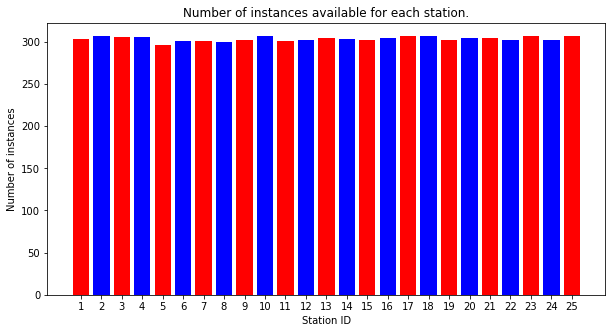

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
station_ids = list(range(1,26))
num_inst_by_station = np.array([len([j for j in range(num_sel_instances) if selected_data['station'][j] == i])
                               for i in range(1,26)])
ax.bar(x=station_ids, height=num_inst_by_station, color=['red', 'blue'])
ax.set_xticks(station_ids)
title = "Number of instances available for each station."
xlabel = "Station ID"
ylabel = "Number of instances"
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
fig.savefig(img_folder + "barplot_num_instances_per_station.png")
plt.show()

We conclude that even after the elimination of the instances with missing values the number of instances available for different stations are similar and are all about $300$ instances. 

### Exploratory Data Analysis

Now that we are done with importing the data and have removed the (small fraction of ) instances with missing values, we proceed to the stage of exploratory data analysis. The purpose of this stage is to investigate and hopefully gain some insights into the possible relations between different attributes and into possible patterns in the data. The EDA will also work as our first step in feature engineering, specially feature selection. 

We begin by investigating the Pearson correlations between different features.

In [8]:
corr = selected_data.iloc[:, 2:].corr()

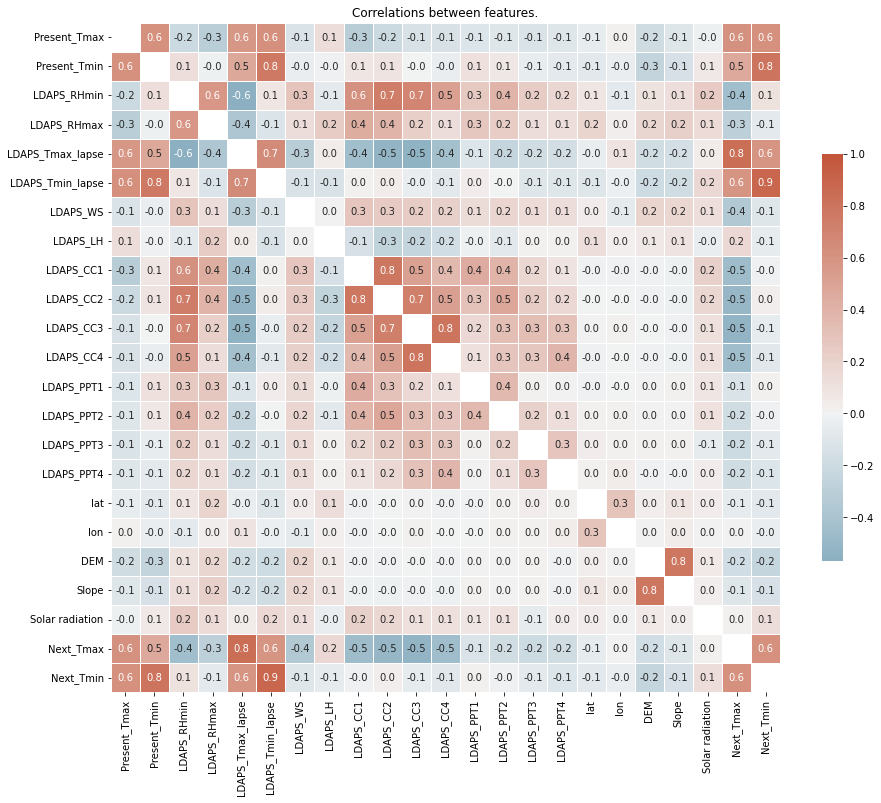

In [9]:
mask = np.zeros_like(corr, dtype=bool)
for i in range(mask.shape[0]):
    mask[i, i] = True
fig, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, ax=ax, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f")
title = "Correlations between features."
ax.set_title(title)
fig.savefig(img_folder + "correlations_heatmap.png")
plt.show()

Since our goal is to estimate the next-day maximum temperature, and because there is a large number of pairs of features to consider, we first bring our attention exlusively to the correlation coefficients between pairs of features consisting of the next-day temperature and another feature.

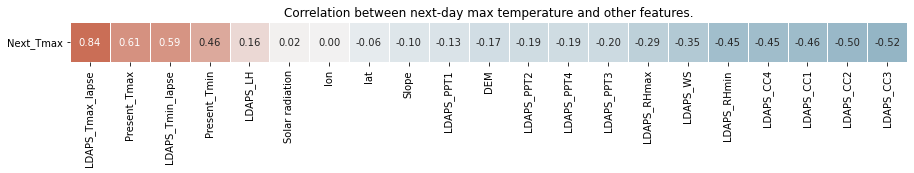

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
cols = list(selected_data.columns)
cols.remove('Next_Tmax')
cols.remove('index')
cols.remove('station')
cols.remove('Date')
cols.remove('Next_Tmin')
sorted_by_corr = sorted(cols, key=lambda x: (corr[x])[-2], reverse=True)
sorted_tcorrs = np.array([(corr[c])[-2] for c in sorted_by_corr])
target_corr = corr.iloc[-2, :]
n = len(sorted_tcorrs)
sns.heatmap(np.array(sorted_tcorrs).reshape((1, n)), ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
           yticklabels=['Next_Tmax'], xticklabels=sorted_by_corr)
title = "Correlation between next-day max temperature and other features."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "target_correlations_heatmap.png")
plt.show()

Having the correlations computed for each pair of features, if each pair of features followed a bivariate normal distribution, we could compute p-values to test the statistical significance of the correlation coefficient.

In the cell below, we perform the Shapiro-Wilk normality test for each numerical feature.

In [11]:
cols = list(selected_data.columns)
for c in ['index', 'station', 'Date']:
    cols.remove(c)
for c in cols:
    pval = scipy.stats.shapiro(selected_data[c])[1]
    normality = pval > 0.95
    if normality:
        print("For feature " + c + " the Shapiro-Wilk normality test did not rejected the null-hypothesis.")

C:\Users\pmkra\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


We note that for all features the Shapiro-Wilk normality test rejected the null-hypothesis (the hypothesis about the normality of the data).
For this reason, we shall not be performing bivariate normality tests for any pair of features and we will consider that the data, including any one feature or any pair of features, is **not** normally sampled and we will not be computing p-values, since the theory of this kind of hypothesis testing assumes that the dataset is normally sampled.

Since we will not be computing p-values, for each pair of variables we will assess the significance of the correlation coefficient based on its absolute value and by comparison to the correlation coefficients of other pairs of features. To be clear, from this point on, when we mention a correlation coefficient being significant, we do not mean it in the statistical hypothesis-testing sense, since we will not be computing p-values. Instead, the significance here is assessed by absolute value and comparison to other correlation coefficients.  

Note that the pair of features 'Present_Tmax' and 'Next_Tmax' are significantly and positively correlated, with correlation value of $0.61$. This goes in accordance with one's intuition that the maximum temperature in two consecutive days should not be too distant.

The pair of features 'Present_Tmin' and 'Next_Tmax' are also significantly and positively correlated, with correlation value of $0.46$. This again goes in accordance with one's intuition that temperatures between two consecutive days, whether they are minimum or maximum, should not be too distant.

In what follows, we present scatter plots for different pairs of features. For each pair of features, say $x$ and $y$, we present the scatter plot of $x$ and $y$, together with the graph of the function $\hat{f}$ obtained by linear regression with $x$ as regressor variable and $y$ as target variable. We also display the correlation between the two variables.

In [12]:
def ScatterPlotSimpleReg(df, x, y, ax, deg=1, loc='best'):
    xdata = df[x]
    ydata = df[y]
    xy = np.vstack([xdata,ydata])
    z = scipy.stats.gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    xdata, ydata, z = xdata[idx], ydata[idx], z[idx]
    
    corr = np.corrcoef(df[x], df[y])[0][1]
    coeffs = np.polyfit(df[x], df[y], deg=deg)
    f_hat = np.poly1d(coeffs)
    x_domain = np.linspace(min(df[x]), max(df[x]), num=1000)
    pred_y = f_hat(x_domain)
    ax.scatter(xdata, ydata, marker='x', c=z, s=50, alpha=0.35, label="original data", cmap=cm.coolwarm)
    #ax.scatter(df[x], df[y], marker='x', color='blue', alpha=0.1, label='original data')
    ax.plot(x_domain, pred_y, linestyle='-', color='red', linewidth=2.5, label="regression, degree = " + str(deg))
    title = ("Scatter: " + x + " and " +  y)
    xlabel = x
    ylabel = y
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc=loc)
    ax.text(min(df[x]), 1.005 * min(df[y]), "$Corr $ = " + "{:.2f}".format(corr) )

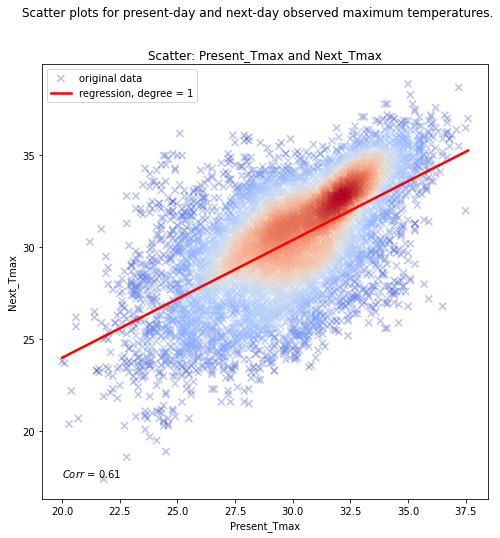

In [13]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
x = 'Present_Tmax'
y = 'Next_Tmax'
ScatterPlotSimpleReg(selected_data, x, y, ax)
title = "Scatter plots for present-day and next-day observed maximum temperatures."
fig.suptitle(title)
fig.savefig(img_folder + "presentmax_nextmax_scatter.png")
plt.show()

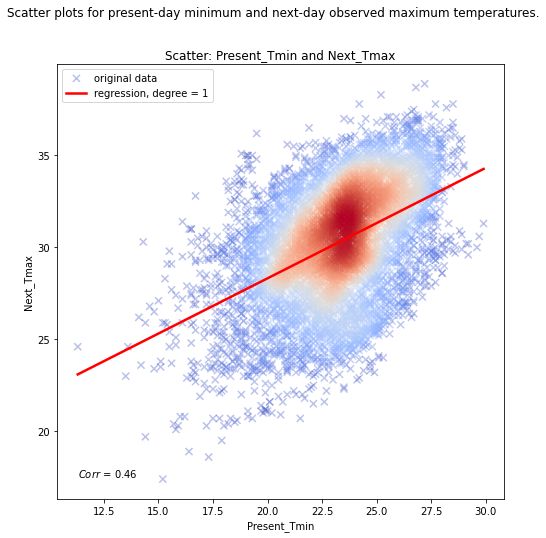

In [14]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
x = 'Present_Tmin'
y = 'Next_Tmax'
ScatterPlotSimpleReg(selected_data, x, y, ax)
title = "Scatter plots for present-day minimum and next-day observed maximum temperatures."
fig.suptitle(title)
fig.savefig(img_folder + "presentmin_nextmax_scatter.png")
plt.show()

We also note that, as one could expect from the definition of these two features, the pair of features 'LDAPS_Tmax_lapse' and 'Next_Tmax' are significantly and positively correlated, with correlation value of $0.84$. 

And we note that the pair of features 'LDAPS_Tmin_lapse' and 'Next_Tmax' are also significantly and positively correlated, with correlation value of $0.46$.

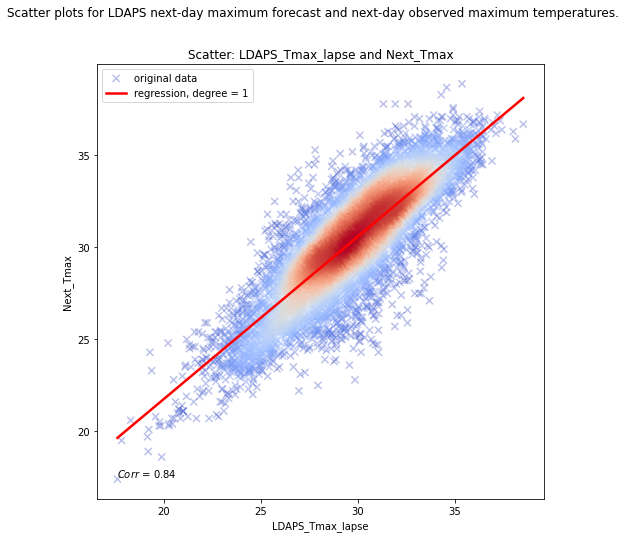

In [15]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
x = 'LDAPS_Tmax_lapse'
y = 'Next_Tmax'
ScatterPlotSimpleReg(selected_data, x, y, ax)
title = "Scatter plots for LDAPS next-day maximum forecast and next-day observed maximum temperatures."
fig.suptitle(title)
fig.savefig(img_folder + "ldapsmax_nextmax_scatter.png")
plt.show()

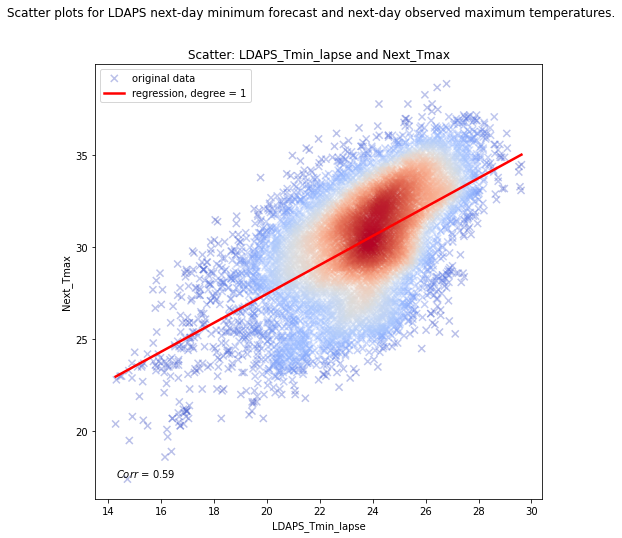

In [16]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
x = 'LDAPS_Tmin_lapse'
y = 'Next_Tmax'
ScatterPlotSimpleReg(selected_data, x, y, ax)
title = "Scatter plots for LDAPS next-day minimum forecast and next-day observed maximum temperatures."
fig.suptitle(title)
fig.savefig(img_folder + "ldapsmin_nextmax_scatter.png")
plt.show()

Due to the definition of the features 'Present_Tmax', 'Present_Tmin', 'LDAPS_Tmax_lapse' and 'LDAPS_Tmin_lapse' and the quantities they measure, is really not surprising that these features are significantly correlated with the feature 'Next_Tmax'.

The scatterplots presented above **suggest** that both 'Present_Tmax' and 'LDAPS_Tmax_lapse' are very significant as predictor variables for the estimation of 'Next_Tmax', and that 'Present_Tmin' and 'LDAPS_Tmin_lapse' are also significant, even if slightly less.

These four features seem to be the only ones which are significantly and positively correlated to 'Next_Tmax'.

We now proceed to the features with significant and negative correlation.

We begin by noting that the pair of features 'LDAPS_RHmin' and 'Next_Tmax' are significantly and negatively correlated, with correlation value of $-0.45$.

On the other hand, the pair of features 'LDAPS_RHmax' and 'Next_Tmax' are not as significantly correlated, with correlation value of $-0.29$.

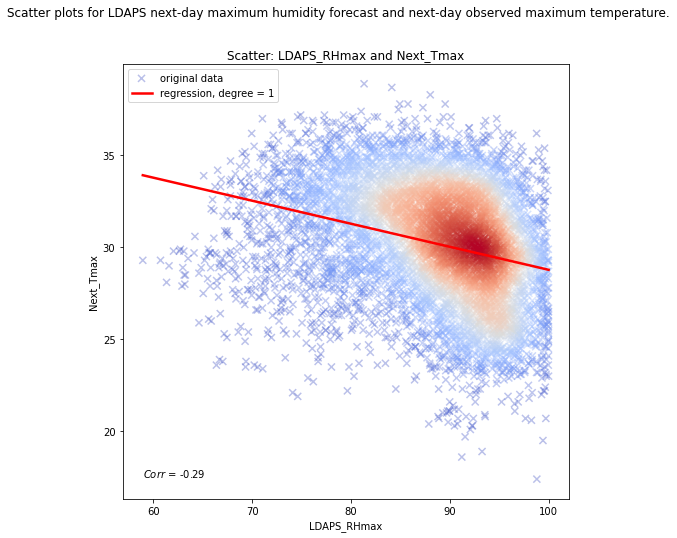

In [17]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
x = 'LDAPS_RHmax'
y = 'Next_Tmax'
ScatterPlotSimpleReg(selected_data, x, y, ax)
title = "Scatter plots for LDAPS next-day maximum humidity forecast and next-day observed maximum temperature."
fig.suptitle(title)
fig.savefig(img_folder + "ldapsrhmax_nextmax_scatter.png")
plt.show()

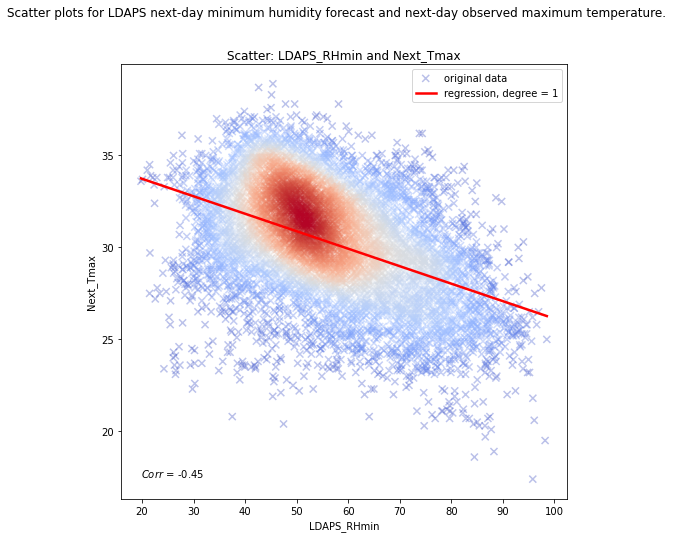

In [18]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
x = 'LDAPS_RHmin'
y = 'Next_Tmax'
ScatterPlotSimpleReg(selected_data, x, y, ax)
title = "Scatter plots for LDAPS next-day minimum humidity forecast and next-day observed maximum temperature."
fig.suptitle(title)
fig.savefig(img_folder + "ldapsrhmin_nextmax_scatter.png")
plt.show()

We also note that for each $n=1,2,3,4$, the pair of features 'LDAPS_CCn' and 'Next_Tmax' are significantly and negatively correlated, with correlation values around $-0.5$.

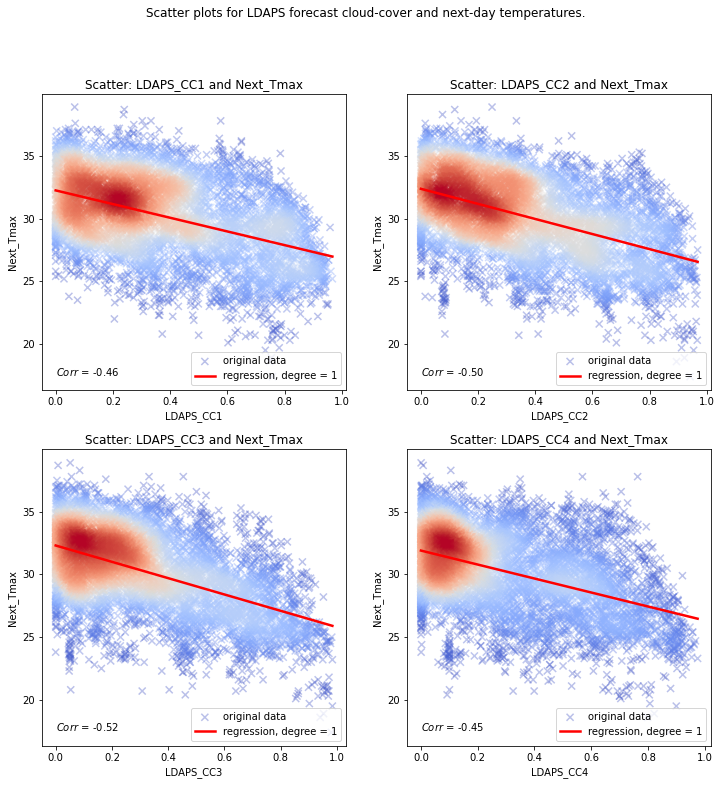

In [19]:
fig, ax  = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
x = 'LDAPS_CC1'
ScatterPlotSimpleReg(selected_data, x, y, ax[0][0], loc='lower right')
x = 'LDAPS_CC2'
ScatterPlotSimpleReg(selected_data, x, y, ax[0][1], loc='lower right')
x = 'LDAPS_CC3'
ScatterPlotSimpleReg(selected_data, x, y, ax[1][0], loc='lower right')
x = 'LDAPS_CC4'
ScatterPlotSimpleReg(selected_data, x, y, ax[1][1], loc='lower right')
title = "Scatter plots for LDAPS forecast cloud-cover and next-day temperatures."
fig.suptitle(title)
fig.savefig(img_folder + "ldapscc_nextmax_scatter.png")
plt.show()

We see that the features 'LDAPS_RHmin' and 'LDAPS_CCn', for $n=1,2,3,4$, are significantly and negatively correlated with 'Next_Tmax'. 
However, from the pairwise correlation heatmap presented above, one can also see that each pair of features 'LDAPS_RHmin' and 'LDAPS_CCn', for each $n=1,2,3,4$, are significantly and positively correlated, with correlation coefficients of $0.6, 0.7, 0.7$ and $0.5$, respectively.

We investigate the relations between these variable in more detail below.

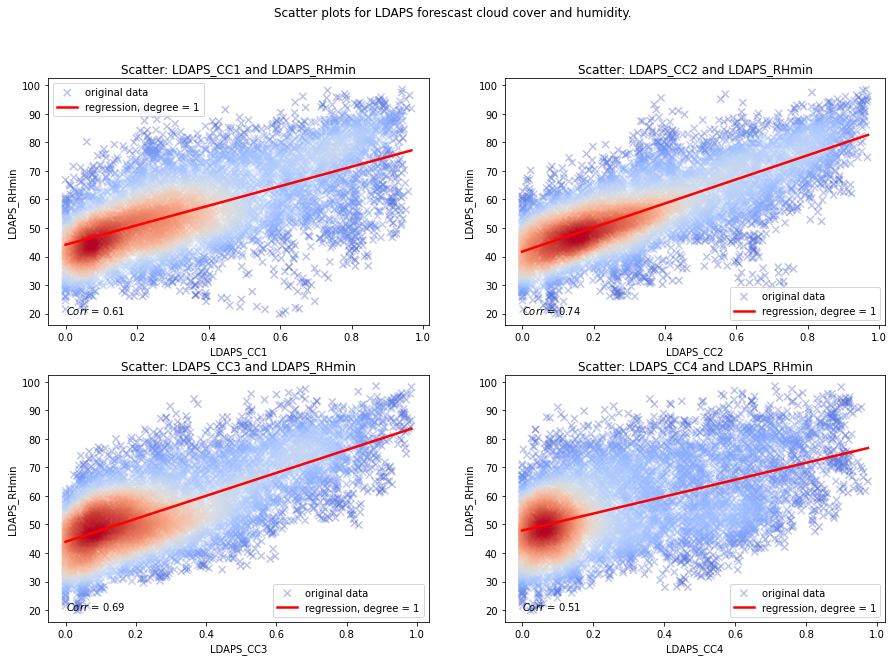

In [20]:
fig, ax  = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
x = 'LDAPS_CC1'
y = 'LDAPS_RHmin'
ScatterPlotSimpleReg(selected_data, x, y, ax[0][0])
x = 'LDAPS_CC2'
ScatterPlotSimpleReg(selected_data, x, y, ax[0][1])
x = 'LDAPS_CC3'
ScatterPlotSimpleReg(selected_data, x, y, ax[1][0])
x = 'LDAPS_CC4'
ScatterPlotSimpleReg(selected_data, x, y, ax[1][1])
title = "Scatter plots for LDAPS forescast cloud cover and humidity."
fig.suptitle(title)
fig.savefig("ldapstemp_nextmax_scatter.png")
plt.show()

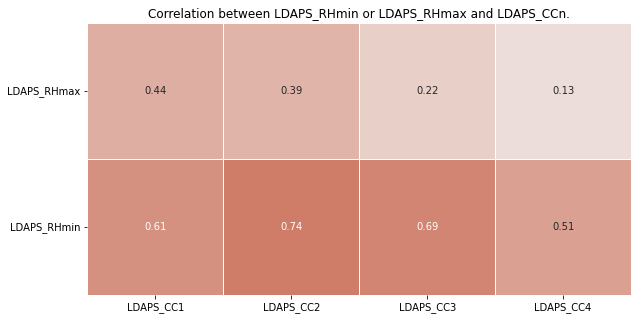

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
rh_cc_corrs = np.zeros((2, 4))
cc_cols = ['LDAPS_CC' + str(j) for j in range(1,5)]
for i,c in enumerate(cc_cols):
    rh_cc_corrs[0, i] = corr[c][3]
for i,c in enumerate(cc_cols):
    rh_cc_corrs[1, i] = corr[c][2]
sns.heatmap(rh_cc_corrs, ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f", 
            yticklabels=['LDAPS_RHmax', 'LDAPS_RHmin'], xticklabels=cc_cols)
title = "Correlation between LDAPS_RHmin or LDAPS_RHmax and LDAPS_CCn."
ax.set_title(title)
fig.savefig(img_folder + "rh_cc_correlations.png")
plt.yticks(rotation=0)
plt.show()

Indeed there are significant correlations between the features 'LDAPS_RHmin' and 'LDAPS_CCn', for each $n=1,2,3,4$. This is something we must keep in mind, specially when we move on to feature selection.

We also note that the features 'LDAPS_CCn', for $n=1,2,3,4$, are pairwise very significantly and positively correlated. This is not really surprising, since they denote the LDAPS cloud cover forecast for different quartes of the same day.

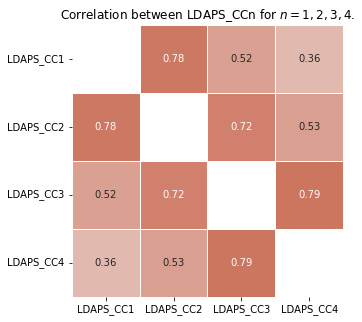

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
rh_cc_corrs = np.zeros((4, 4))
mask = np.zeros_like(rh_cc_corrs, dtype=bool)
for i in range(mask.shape[0]):
    mask[i, i] = True
cc_cols = ['LDAPS_CC' + str(j) for j in range(1,5)]
for i,c in enumerate(cc_cols):
    for j, cc in enumerate(cc_cols):
        rh_cc_corrs[i, j] = corr[c][8+j]
sns.heatmap(rh_cc_corrs, ax=ax, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
           yticklabels=cc_cols, xticklabels=cc_cols)
title = "Correlation between LDAPS_CCn for $n=1,2,3,4$."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "cc_self_correlations.png")
plt.show()

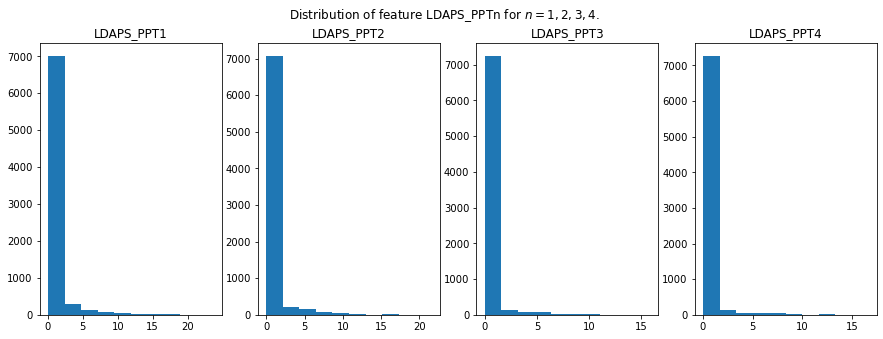

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,5))
for i, c in enumerate(['LDAPS_PPT' + str(n) for n in range(1,5)]):
    ax[i].hist(selected_data[c], bins=10)
    ax[i].set_title(c)
title = "Distribution of feature LDAPS_PPTn for $n=1,2,3,4$."
fig.suptitle(title)
fig.savefig(img_folder + "hist_ppt.png")
plt.show()

As we can see from the histograms above, for each $n=1,2,3,4$, most of the values of the feature 'LDAPS_PPTn' are equal to zero.

Moreover, for each $n=1,2,3,4$, the correlation coefficient for the pair of features 'LDAPS_PPTn' and 'Next_Tmax' or 'Next_Tmin' is not significant.
This might be caused by the skewness of the distribution of 'LDAPS_PPTn', for $n=1,2,3,4$.

Below we introduce four binary variables 'LDAPS_BINARY_RAINn', for $n=1,2,3,4$.
For each $n=1,2,3,4$ and each instance, 'LDAPS_BINARY_RAINn' is a binary variable which denotes whether the corresponding value of 'LDAPS_PPTn' is different than zero.

In [24]:
rain_next_corrs = np.zeros((2, 4))
rain_cc_corrs = np.zeros((4, 4))
for i, c in enumerate(['LDAPS_PPT' + str(n) for n in range(1,5)]):
    pos_vals = np.array([int(selected_data[c][j] > 0) for j in range(num_sel_instances)])
    col = 'LDAPS_BINARY_RAIN' + str(i+1)
    selected_data[col] = pos_vals
    c = np.corrcoef(pos_vals, selected_data['Next_Tmax'])[0,1]
    rain_next_corrs[0, i] = c
    c = np.corrcoef(pos_vals, selected_data['Next_Tmin'])[0,1]
    rain_next_corrs[1, i] = c
    for j,v in enumerate(['LDAPS_CC' + str(j) for j in range(1,5)]):
        c = np.corrcoef(pos_vals, selected_data[v])[0,1]
        rain_cc_corrs[i, j] = c

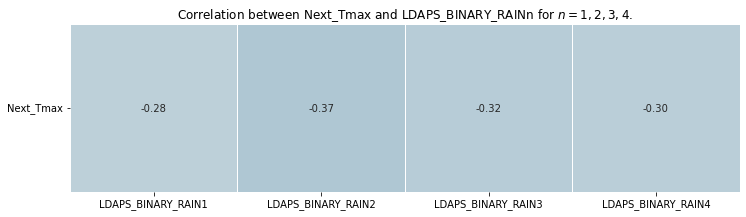

In [25]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(np.array(rain_next_corrs[0, :]).reshape((1,4)), ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
           yticklabels=['Next_Tmax'], xticklabels=['LDAPS_BINARY_RAIN' + str(n) for n in range(1,5)])
title = "Correlation between Next_Tmax and LDAPS_BINARY_RAINn for $n=1,2,3,4$."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "next_binaryrain_correlations.png")
plt.show()

We can see that the pairs of features 'LDAPS_BINARY_RAINn', for $n=1,2,3,4$, and 'Next_Tmax' are significantly and negatively correlated, with values around $-0.3$.

On the other, from the definion of 'LDAPS_BINARY_RAINn', for $n=1,2,3,4$, these variables consequently have a high correlation with 'LDAPS_PPTn', for $n=1,2,3,4$.
This is presented below.

As expected by their definition and from knowledge about metereology, and as shown by the collected data, there are four groups of features which are significantly correlated, namely the features: 'LDAPS_RHmin' and 'LDAPS_RHmax', the group of features related to relative humidity; 'LDAPS_CCn', for $n=1,2,3,4$, the group of features related to cloud cover; 'LDAPS_PPTn', for $n=1,2,3,4$, the group of features related to precipitation; 'LDAPS_BINARY_RAINn', for $n=1,2,3,4$, the group of features related to the ocurrence or not of precipitation. 
All these features are all related, to some degree, to relative humidity and precipitation, and hence each pair of these features is significantly correlated.

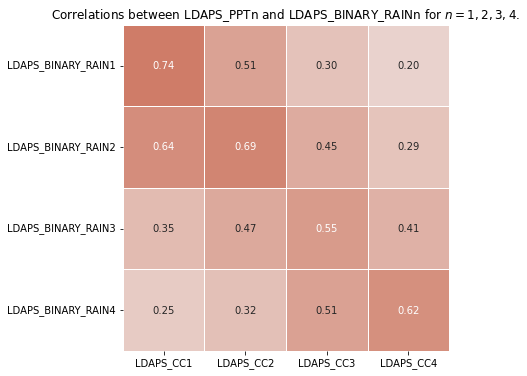

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(rain_cc_corrs, ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
           yticklabels=['LDAPS_BINARY_RAIN' + str(n) for n in range(1,5)], xticklabels=['LDAPS_CC' + str(j) for j in range(1,5)])
title = "Correlations between LDAPS_PPTn and LDAPS_BINARY_RAINn for $n=1,2,3,4$."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "rain_cc_correlations.png")
plt.show()

In [27]:
rh_rain_corrs = np.zeros((2, 4))
for i, v in enumerate(['LDAPS_BINARY_RAIN' + str(n) for n in range(1,5)]):
    c = np.corrcoef(selected_data[v], selected_data['LDAPS_RHmax'])[0,1]
    rh_rain_corrs[0, i] = c
    c = np.corrcoef(selected_data[v], selected_data['LDAPS_RHmin'])[0,1]
    rh_rain_corrs[1, i] = c

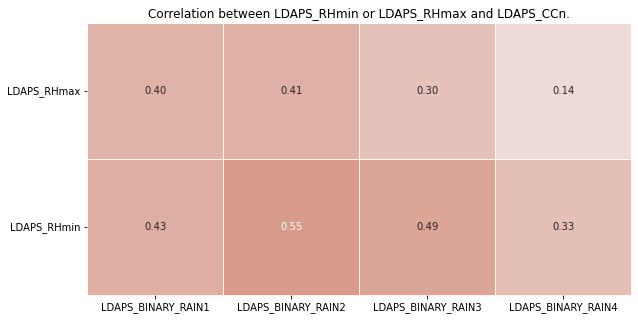

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(rh_rain_corrs, ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f", 
            yticklabels=['LDAPS_RHmax', 'LDAPS_RHmin'], xticklabels=['LDAPS_BINARY_RAIN' + str(n) for n in range(1,5)])
title = "Correlation between LDAPS_RHmin or LDAPS_RHmax and LDAPS_CCn."
ax.set_title(title)
fig.savefig(img_folder + "rh_rain_correlations.png")
plt.yticks(rotation=0)
plt.show()

Now we consider the relation between 'LDAPS_WS', the LDAPS model forecast wind speed, and the target next-day max temperature.

The correlation for the pair 'LDAPS_WS' and 'Next_Tmax' is slightly significant and negative, with value $-0.35$.

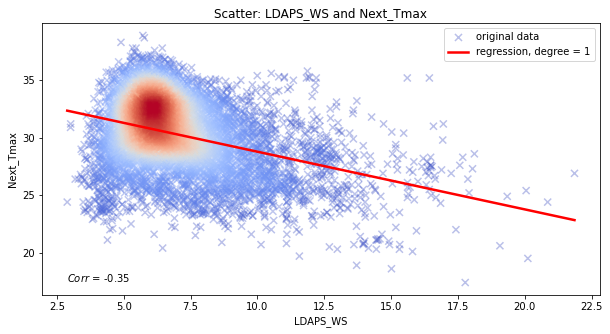

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
x = 'LDAPS_WS'
y = 'Next_Tmax'
ScatterPlotSimpleReg(selected_data, x, y, ax, deg=1, loc='best')
fig.savefig(img_folder + "next_ws_scatter.png")

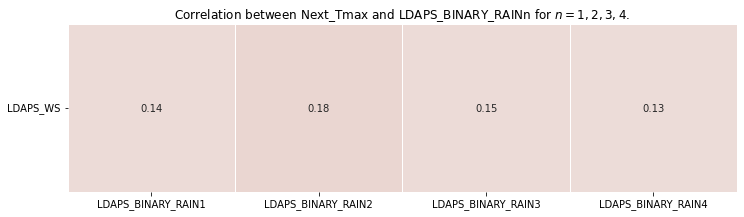

In [30]:
ws_rain_corrs = np.zeros((1,4))
for i,v in enumerate(['LDAPS_PPT' + str(n) for n in range(1,5)]):
    c = np.corrcoef(selected_data[v], selected_data['LDAPS_WS'])[0,1]
    ws_rain_corrs[0, i] = c
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(ws_rain_corrs, ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
           yticklabels=['LDAPS_WS'], xticklabels=['LDAPS_BINARY_RAIN' + str(n) for n in range(1,5)])
title = "Correlation between Next_Tmax and LDAPS_BINARY_RAINn for $n=1,2,3,4$."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "next_binaryrain_correlations.png")
plt.show()

Now we consider the relation between 'LDAPS_WS', the LDAPS model forecast wind speed, and the target next-day max temperature.

The correlation for the pair 'LDAPS_LH' and 'Next_Tmax' is not very significant, with value $0.16$.

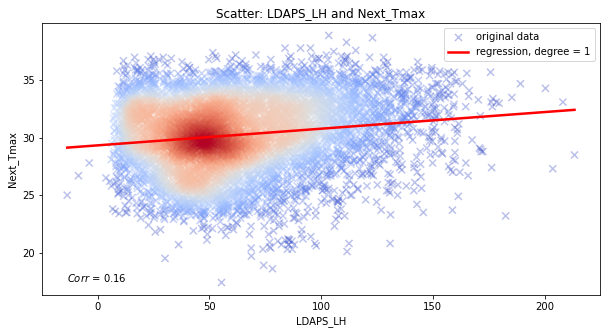

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
x = 'LDAPS_LH'
y = 'Next_Tmax'
ScatterPlotSimpleReg(selected_data, x, y, ax, deg=1, loc='best')
fig.savefig(img_folder + "next_ws_scatter.png")

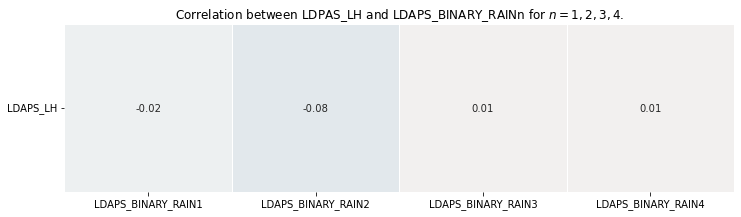

In [32]:
ws_rain_corrs = np.zeros((1,4))
for i,v in enumerate(['LDAPS_PPT' + str(n) for n in range(1,5)]):
    c = np.corrcoef(selected_data[v], selected_data['LDAPS_LH'])[0,1]
    ws_rain_corrs[0, i] = c
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(ws_rain_corrs, ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
           yticklabels=['LDAPS_LH'], xticklabels=['LDAPS_BINARY_RAIN' + str(n) for n in range(1,5)])
title = "Correlation between LDPAS_LH and LDAPS_BINARY_RAINn for $n=1,2,3,4$."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "lh_rain_correlations.png")
plt.show()

Now we consider the relation between the solar radiation and the target next-day max temperature.

The correlation for the pair 'Solar radiation' and 'Next_Tmax' is not very significant, with value $0.02$.

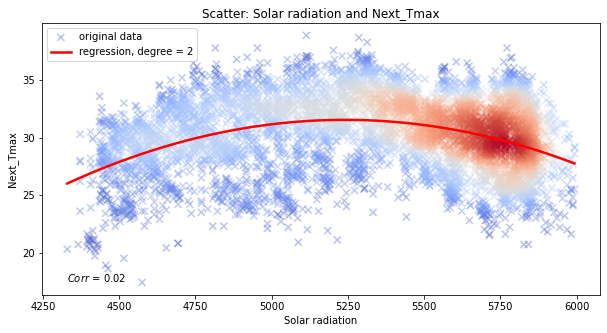

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
x = 'Solar radiation'
y = 'Next_Tmax'
ScatterPlotSimpleReg(selected_data, x, y, ax, deg=2, loc='best')
fig.savefig(img_folder + "next_ws_scatter.png")

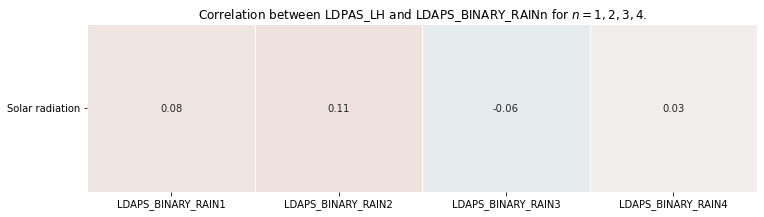

In [34]:
ws_rain_corrs = np.zeros((1,4))
for i,v in enumerate(['LDAPS_PPT' + str(n) for n in range(1,5)]):
    c = np.corrcoef(selected_data[v], selected_data['Solar radiation'])[0,1]
    ws_rain_corrs[0, i] = c
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(ws_rain_corrs, ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
           yticklabels=['Solar radiation'], xticklabels=['LDAPS_BINARY_RAIN' + str(n) for n in range(1,5)])
title = "Correlation between LDPAS_LH and LDAPS_BINARY_RAINn for $n=1,2,3,4$."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "lh_rain_correlations.png")
plt.show()

Finally, we consider the three geographical attributes associated with each station.

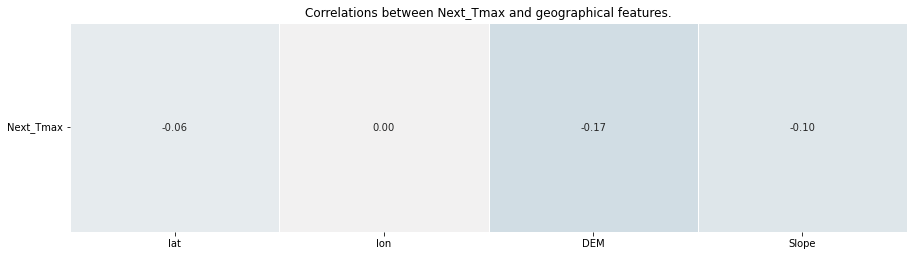

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
geo_next_corrs = np.zeros((2, 4))
cols = ['lat', 'lon', 'DEM', 'Slope']
for i,c in enumerate(cols):
    geo_next_corrs[0, i] = corr[c][-2]
for i,c in enumerate(cols):
    geo_next_corrs[1, i] = corr[c][-1]
sns.heatmap(np.array(geo_next_corrs[0, :]).reshape((1,4)), ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f", 
            yticklabels=['Next_Tmax'], xticklabels=cols)
title = "Correlations between Next_Tmax and geographical features."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "next_geo_correlations.png")
plt.show()

Since all stations are located within Seoul, the distribution of the latitude and longitude coordinates of the different stations is concentrated on a small interval.

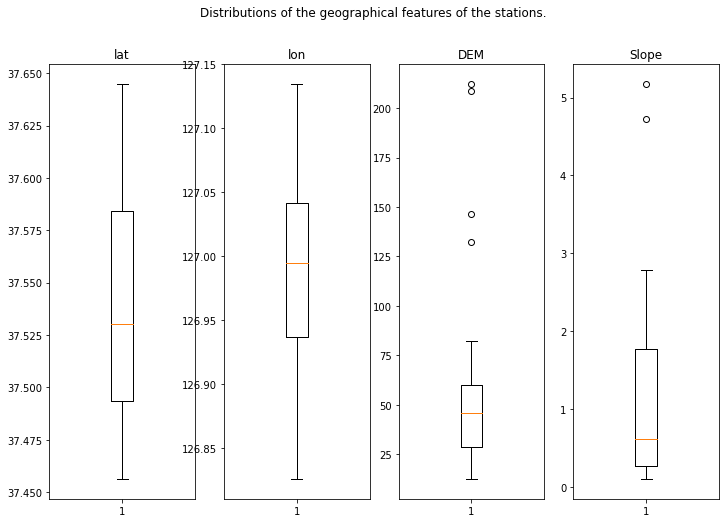

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,8))
for i, c in enumerate(['lat', 'lon', 'DEM', 'Slope']):
    ax[i].boxplot(x=selected_data[c].unique())
    ax[i].set_title(c)
title = "Distributions of the geographical features of the stations."
fig.suptitle(title)
fig.savefig(img_folder + "geo_boxplots.png")
plt.show()

Since the values of latitude and longitude are so concentrated, the features 'lat' and 'lon' do not seem to be relevant predictor variables for the estimation of next-day minimum and maximum temperatures, as suggested by the nearly zero correlation coefficients. 

On the other hand, the features 'DEM' (which denotes elevation) and 'Slope' presented a greater correlation coefficient with both the next-day minumin and the next-day maximum temperature. Moreover, since the stations are all located in the same region and therefore have similar latitudes and longitudes, these two features might prove to be useful for differing the different stations.

### Train-Test Split and Cross Validation

In the following cells, we partition the dataset into train and test set, each one with $0.75\%$ and $0.25\%$ of the data, respectively.

In [37]:
def ZScoreGetNormalizer(df : pd.DataFrame, mut_cols):
    zscaler = sklearn.preprocessing.StandardScaler()
    zscaler.fit(X=df[mut_cols])
    return zscaler

def ZScoreNormalizeDF(df : pd.DataFrame, mut_cols, const_cols, normalizer):
    normalized_data = pd.DataFrame(normalizer.transform(df[mut_cols]), columns=mut_cols)
    normalized_data[const_cols] = df[const_cols]
    return normalized_data

def ZScoreInverseNormalizeDF(df : pd.DataFrame, mut_cols, const_cols, normalizer):
    inv_normalized_data = pd.DataFrame(normalizer.inverse_transform(df[mut_cols]), columns=mut_cols)
    inv_normalized_data[const_cols] = df[const_cols]
    return inv_normalized_data

In [38]:
input_cols = ['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse',
       'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3',
       'LDAPS_CC4','lat', 'lon', 'DEM', 'Slope', 'Solar radiation', 'LDAPS_BINARY_RAIN1', 'LDAPS_BINARY_RAIN2',
       'LDAPS_BINARY_RAIN3', 'LDAPS_BINARY_RAIN4']
target_col = 'Next_Tmax'
mut_cols = ['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse',
       'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3',
       'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4',
       'lat', 'lon', 'DEM', 'Slope', 'Solar radiation']
const_cols = ['LDAPS_BINARY_RAIN1', 'LDAPS_BINARY_RAIN2',
       'LDAPS_BINARY_RAIN3', 'LDAPS_BINARY_RAIN4', 'Next_Tmax']
all_cols = ['Present_Tmax', 'Present_Tmin',
       'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse',
       'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3',
       'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4',
       'lat', 'lon', 'DEM', 'Slope', 'Solar radiation', 'LDAPS_BINARY_RAIN1', 'LDAPS_BINARY_RAIN2',
       'LDAPS_BINARY_RAIN3', 'LDAPS_BINARY_RAIN4', 'Next_Tmax']

In [39]:
train_data, test_data = train_test_split(selected_data, test_size=0.25, random_state=0, stratify=selected_data['station'])
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_normalizer = ZScoreGetNormalizer(df=train_data, mut_cols=mut_cols)
normalized_train_data = ZScoreNormalizeDF(df=train_data, mut_cols=mut_cols, const_cols=const_cols, normalizer=train_normalizer)
test_normalizer = ZScoreGetNormalizer(df=test_data, mut_cols=mut_cols)
normalized_test_data = ZScoreNormalizeDF(df=test_data, mut_cols=mut_cols, const_cols=const_cols, normalizer=test_normalizer)

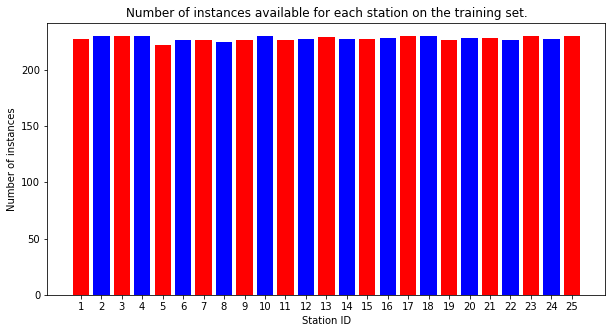

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
station_ids = list(range(1,26))
num_inst_by_station = np.array([len([j for j in range(train_data.shape[0]) if train_data['station'][j] == i])
                               for i in range(1,26)])
ax.bar(x=station_ids, height=num_inst_by_station, color=['red', 'blue'])
ax.set_xticks(station_ids)
title = "Number of instances available for each station on the training set."
xlabel = "Station ID"
ylabel = "Number of instances"
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
fig.savefig(img_folder + "barplot_num_instances_per_station_train.png")
plt.show()

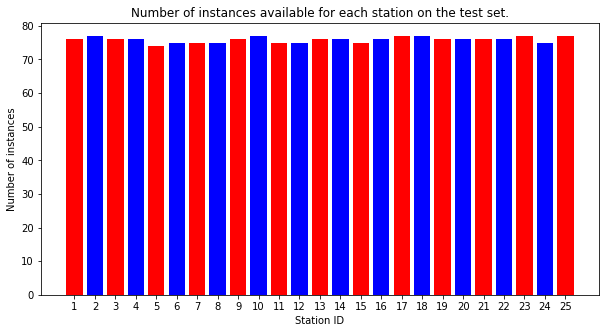

In [41]:
fig, ax = plt.subplots(figsize=(10,5))
station_ids = list(range(1,26))
num_inst_by_station = np.array([len([j for j in range(test_data.shape[0]) if test_data['station'][j] == i])
                               for i in range(1,26)])
ax.bar(x=station_ids, height=num_inst_by_station, color=['red', 'blue'])
ax.set_xticks(station_ids)
title = "Number of instances available for each station on the test set."
xlabel = "Station ID"
ylabel = "Number of instances"
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
fig.savefig(img_folder + "barplot_num_instances_per_station_test.png")
plt.show()

And in the next cells we further partition the training set into $10$ different folds for cross validation. For each fold, we initiate and store a transformer object which performs z-score normalization on data. The $k$-th transformer is "trained" using the training data of the $k$-th CV fold and is then applied to both the training data and test data of that fold.

In [42]:
k = 10
k_fold_train_data = [None for i in range(k)]
k_fold_test_data = [None for i in range(k)]
k_fold_train_target = [None for i in range(k)]
k_fold_test_target = [None for i in range(k)]
k_fold_normalized_train_data = [None for i in range(k)]
k_fold_normalized_test_data = [None for i in range(k)]
k_fold_normalizers = [None for i in range(k)]
cv = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
#cv = KFold(n_splits=10, shuffle=True, random_state=0)
for i, fold_inds in enumerate(cv.split(train_data, train_data['station'])):
    train_inds, test_inds = fold_inds
    k_fold_train_data[i] = copy.copy(train_data.iloc[train_inds, :]).reset_index(drop=True)
    k_fold_test_data[i] = copy.copy(train_data.iloc[test_inds, :]).reset_index(drop=True)
    k_fold_train_target[i] = copy.copy(train_data[target_col][train_inds])
    k_fold_test_target[i] = copy.copy(train_data[target_col][test_inds])
    normalizer = ZScoreGetNormalizer(df=k_fold_train_data[i], mut_cols=mut_cols)
    k_fold_normalizers[i] = copy.deepcopy(normalizer)
    k_fold_normalized_train_data[i] = ZScoreNormalizeDF(df=k_fold_train_data[i], mut_cols=mut_cols, const_cols=const_cols, normalizer=normalizer)
    k_fold_normalized_test_data[i] = ZScoreNormalizeDF(df=k_fold_test_data[i], mut_cols=mut_cols, const_cols=const_cols, normalizer=normalizer)

### Feature Selection

Now we would like to assess the importance of each feature for predicting the next-day maximum temperature.

We begin by considering a so-called ''embedded method''. The procedure is described below.

We will be considering Ridge and Lasso regression models. Since both Ridge and Lasso include a term on the objective function that penalizes greater values of the coefficients, the hpoeful idea is that both Lasso and Ridge, because of the penalty term, will prioritize the regressor variables most relevant to predict the target variable. The assessment of the importance of each regressor variable is given by the absolute value its regression coefficient. Greater absolute values are understood as greater importance.

Since both Ridge and Lasso depend on a hyperparameter $\alpha$ which controls the level of penalty on the coefficients, we make use of $10$ fold cross-validation.

The procedure is described in detail as follows. We perform the following procedure once for Ridge and once for Lasso.
    
1. We specify a finite set $A \subseteq \mathbb{R}$ of values which are evenly spaced on a logarithmic scale.

2. Initialize a variable $\alpha^* = \emptyset$, meant to store the value of $\alpha$ that leads to the model with best metric, and initialize $m^* = \infty$, meant to denote the currently best known metric. 
    
3. For each $\alpha \in A$ and each $k \in \{1, \ldots, 10 \}$, we train a model(either Ridge or Lasso) using as training data the training split of the $k$-th cross validation fold. For each fold, we also compute the mean absolute error on the test split of the $k$-th cross validation fold.

4. After training one model for each fold, for each $\alpha \in A$ we have ten different values for the mean absolute error. We compute the maximum $m_{\alpha}$ of these ten errors. If $m_{\alpha} < m^*$, we update $\alpha^* \leftarrow \alpha$ and $m^* \leftarrow m_{\alpha}$.

5. After all the values of $\alpha \in A$ have been explored, we train a model $\hat{f}_{\alpha^*}$ using the whole training set.

6. The absolute value of the coefficient of $\hat{f}_{\alpha^*}$ for a regressor variable is taken as a measure of the importance of that regressor variable for estimating the target variable. Greater absolute values are understood as greater importance.

In [43]:
alpha_grid = np.logspace(-4, 2, 100)
coeffs = {c : [] for c in input_cols}
metrics = []
num_inputs = len(input_cols)
best_metric = math.inf
best_alpha = None
best_coeffs = None
for alpha in tqdm(alpha_grid):
    curr_metrics = []
    coeff_mat = np.zeros((k, num_inputs))
    for i in range(k):
        model = sklearn.linear_model.Ridge(alpha=alpha, fit_intercept=True)
        tr = k_fold_normalized_train_data[i]
        te = k_fold_normalized_test_data[i]
        tr_target = k_fold_train_target[i]
        te_target = k_fold_test_target[i]
        model.fit(X=tr[input_cols], y=tr_target)
        y_pred = model.predict(X=te[input_cols])
        m = sklearn.metrics.mean_squared_error(y_true=te_target, y_pred=y_pred, squared=False)
        curr_metrics.append(m)
        coeff_mat[i, :] = np.array(model.coef_)
    for p, col in enumerate(input_cols):
        coeffs[col].append(abs(np.mean(coeff_mat[:, p])))
    m = np.mean(curr_metrics)
    metrics.append(m)
    if m < best_metric:
        best_metric = m
        best_alpha = alpha
        best_coeffs = np.mean(coeff_mat, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.88it/s]


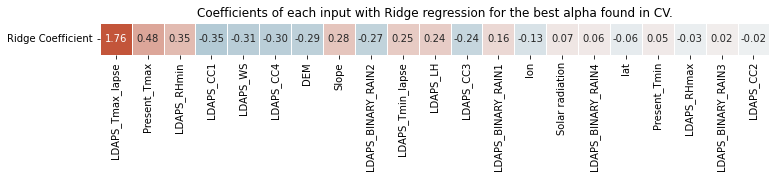

In [44]:
model = sklearn.linear_model.Ridge(alpha=best_alpha, fit_intercept=True)
tr = normalized_train_data
model.fit(X=tr[input_cols], y=tr[target_col])
best_coeffs = model.coef_
ridge_input_ranking = sorted(range(num_inputs), key=lambda x: abs(best_coeffs[x]), reverse=True)
ridge_col_ranking = [input_cols[i] for i in ridge_input_ranking]
ridge_col_coeffs = np.array([best_coeffs[i] for i in ridge_input_ranking]).reshape((1, num_inputs))
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(ridge_col_coeffs, ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
           yticklabels=['Ridge Coefficient'], xticklabels=ridge_col_ranking)
title = "Coefficients of each input with Ridge regression for the best alpha found in CV."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "selection_ridge_coeff.png")
plt.show()

In [45]:
alpha_grid = np.logspace(-4, 2, 100)
coeffs = {c : [] for c in input_cols}
metrics = []
num_inputs = len(input_cols)
best_metric = math.inf
best_alpha = None
best_coeffs = None
for alpha in tqdm(alpha_grid):
    curr_metrics = []
    coeff_mat = np.zeros((k, num_inputs))
    for i in range(k):
        model = sklearn.linear_model.Lasso(alpha=alpha, fit_intercept=True)
        tr = k_fold_normalized_train_data[i]
        te = k_fold_normalized_test_data[i]
        tr_target = k_fold_train_target[i]
        te_target = k_fold_test_target[i]
        model.fit(X=tr[input_cols], y=tr_target)
        y_pred = model.predict(X=te[input_cols])
        m = sklearn.metrics.mean_squared_error(y_true=te_target, y_pred=y_pred, squared=False)
        curr_metrics.append(m)
        coeff_mat[i, :] = np.array(model.coef_)
    for p, col in enumerate(input_cols):
        coeffs[col].append(abs(np.mean(coeff_mat[:, p])))
    m = np.mean(curr_metrics)
    metrics.append(m)
    if m < best_metric:
        best_metric = m
        best_alpha = alpha
        best_coeffs = np.mean(coeff_mat, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.15it/s]


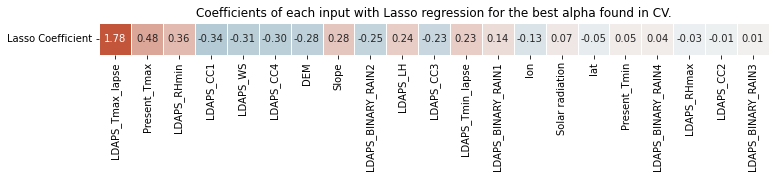

In [46]:
model = sklearn.linear_model.Lasso(alpha=best_alpha, fit_intercept=True)
tr = normalized_train_data
model.fit(X=tr[input_cols], y=tr[target_col])
best_coeffs = model.coef_
lasso_input_ranking = sorted(range(num_inputs), key=lambda x: abs(best_coeffs[x]), reverse=True)
lasso_col_ranking = [input_cols[i] for i in lasso_input_ranking]
lasso_col_coeffs = np.array([best_coeffs[i] for i in lasso_input_ranking]).reshape((1, num_inputs))
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(lasso_col_coeffs, ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".2f",
           yticklabels=['Lasso Coefficient'], xticklabels=lasso_col_ranking)
title = "Coefficients of each input with Lasso regression for the best alpha found in CV."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "selection_lasso_coeff.png")
plt.show()

The previous procedure can also be generalized in order to perform recursive feature selection. Again, we will be considering Ridge and Lasso models. The idea is to begin with a certain set of predictor variables and iteratively remove from this set one variable of least importance.

Since both Ridge and Lasso depend on a hyperparameter $\alpha$ which controls the level of penalty on the coefficients, we make use of $10$ fold cross-validation.

The procedure is described in detail as follows. We perform the following procedure once for Ridge and once for Lasso.

1. Initialize a set $V$, initially containing all the regressor variables.

2. Specify a finite set $A \subseteq \mathbb{R}$ of values which are evenly spaced on a logarithmic scale

2. While $|V| \geq 1$, do the following:
    
    3.2 Initialize a variable $\alpha^* = \emptyset$, meant to store the value of $\alpha$ that leads to the model with best metric, and initialize $m^* = \infty$, meant to denote the currently best known metric. 
    
    3.3 For each $\alpha \in A$ and each $k \in \{1, \ldots, 10 \}$, we train a model(either Ridge or Lasso) using as training data the training split of the $k$-th cross validation fold. The model has as regressor variables only those variables in $V_k$. For each fold, we also compute the mean absolute error on the test split of the $k$-th cross validation fold.

    3.4 After training one model for each fold, for each $\alpha \in A$ we have ten different values for the mean absolute error. We compute the maximum $m_{\alpha}$ of these ten errors. If $m_{\alpha} < m^*$, we update $\alpha^* \leftarrow \alpha$ and $m^* \leftarrow m_{\alpha}$.

    3.5 After all the values of $\alpha \in A$ have been explored, we train a model $\hat{f}_{\alpha^{*}_{k}}$ using the whole training set.
    
    3.6 Store the value of the mean absolute error of $\hat{f}_{\alpha^{*}_{k}}$.

    3.6 The absolute value of the coefficient of $\hat{f}_{\alpha^{*}_{k}}$ for a regressor variable is taken as a measure of the importance of that regressor variable for estimating the target variable. Greater absolute values are understood as greater importance.
    
    3.7 Find the regressor variable $\underline{v} \in V_k$ such that the absolute value of the coefficient of $\underline{v}$ in $\hat{f}_{\alpha^{*}_{k}}$ is the lowest. This variable is considered the least important. Make $V_{k+1} = V_k \setminus \{ \underline{v} \} $.
    
By the end of this procedure, the order in which the regressor variables are removed suggests an increasing sequence of importance of the regressor variables.
Moreover, the values of the mean absolute error stored for each iteration also enables us to analyze the performance of the model for different numbers of regressor variables.
These values are plotted below.

In [47]:
alpha_grid = np.logspace(-4, 2, 30)
ridge_curr_input_cols = copy.copy(input_cols)
lb_num_vars = 0
ridge_metrics = []
ngrid = []
ridge_remove_order = []
for i in tqdm(range(num_inputs)):
#while len(ridge_curr_input_cols) != lb_num_vars:
    curr_n = len(ridge_curr_input_cols)
    best_metric = math.inf
    best_alpha = None
    best_coeffs = None
    for alpha in alpha_grid:
        curr_metrics = []
        coeff_mat = np.zeros((k, curr_n))
        for i in range(k):
            model = sklearn.linear_model.Ridge(alpha=alpha, fit_intercept=True)
            tr = k_fold_normalized_train_data[i]
            te = k_fold_normalized_test_data[i]
            tr_target = k_fold_train_target[i]
            te_target = k_fold_test_target[i]
            model.fit(X=tr[ridge_curr_input_cols], y=tr_target)
            y_pred = model.predict(X=te[ridge_curr_input_cols])
            m = sklearn.metrics.mean_squared_error(y_true=te_target, y_pred=y_pred, squared=False)
            curr_metrics.append(m)
            coeff_mat[i, :] = np.array(model.coef_)
        m = np.mean(curr_metrics)
        if m < best_metric:
            best_metric = m
            best_alpha = alpha
            best_coeffs = np.mean(coeff_mat, axis=0)
    model = sklearn.linear_model.Ridge(alpha=best_alpha, fit_intercept=True)
    tr = normalized_train_data
    model.fit(X=tr[ridge_curr_input_cols], y=tr[target_col])
    best_coeffs = model.coef_
    pred_y = model.predict(X=tr[ridge_curr_input_cols])
    best_metric = sklearn.metrics.mean_absolute_error(y_true=tr[target_col], y_pred=pred_y)
    input_ranking = sorted(range(curr_n), key=lambda x: abs(best_coeffs[x]), reverse=True)
    del_col = ridge_curr_input_cols[input_ranking[-1]]
    ridge_curr_input_cols.remove(del_col)
    ridge_remove_order.append(del_col)
    ridge_metrics.append(best_metric)
    ngrid.append(curr_n)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:28<00:00,  1.35s/it]


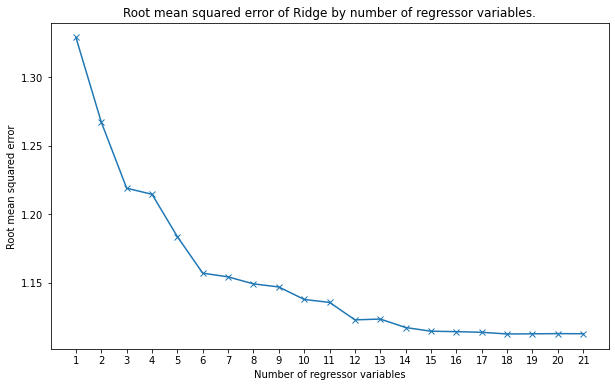

In [48]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(ngrid, ridge_metrics, marker='x')
ax.set_xticks(ngrid)
title = "Root mean squared error of Ridge by number of regressor variables."
ax.set_title(title)
xlabel = "Number of regressor variables"
ylabel = "Root mean squared error"
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
fig.savefig(img_folder + "selection_ridge_num_vars.png")
plt.show()

In [49]:
alpha_grid = np.logspace(-4, 2, 30)
lasso_curr_input_cols = copy.copy(input_cols)
lb_num_vars = 0
lasso_metrics = []
ngrid = []
lasso_remove_order = []
for i in tqdm(range(num_inputs)):
#while len(lasso_curr_input_cols) != lb_num_vars:
    curr_n = len(lasso_curr_input_cols)
    best_metric = math.inf
    best_alpha = None
    best_coeffs = None
    for alpha in alpha_grid:
        curr_metrics = []
        coeff_mat = np.zeros((k, curr_n))
        for i in range(k):
            model = sklearn.linear_model.Lasso(alpha=alpha, fit_intercept=True)
            tr = k_fold_normalized_train_data[i]
            te = k_fold_normalized_test_data[i]
            tr_target = k_fold_train_target[i]
            te_target = k_fold_test_target[i]
            model.fit(X=tr[lasso_curr_input_cols], y=tr_target)
            y_pred = model.predict(X=te[lasso_curr_input_cols])
            m = sklearn.metrics.mean_squared_error(y_true=te_target, y_pred=y_pred, squared=False)
            curr_metrics.append(m)
            coeff_mat[i, :] = np.array(model.coef_)
        m = np.mean(curr_metrics)
        if m < best_metric:
            best_metric = m
            best_alpha = alpha
            best_coeffs = np.mean(coeff_mat, axis=0)
    model = sklearn.linear_model.Lasso(alpha=best_alpha, fit_intercept=True)
    tr = normalized_train_data
    model.fit(X=tr[lasso_curr_input_cols], y=tr[target_col])
    best_coeffs = model.coef_
    pred_y = model.predict(X=tr[lasso_curr_input_cols])
    best_metric = sklearn.metrics.mean_absolute_error(y_true=tr[target_col], y_pred=pred_y)
    input_ranking = sorted(range(curr_n), key=lambda x: abs(best_coeffs[x]), reverse=True)
    del_col = lasso_curr_input_cols[input_ranking[-1]]
    lasso_curr_input_cols.remove(del_col)
    lasso_remove_order.append(del_col)
    lasso_metrics.append(best_metric)
    ngrid.append(curr_n)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:36<00:00,  1.75s/it]


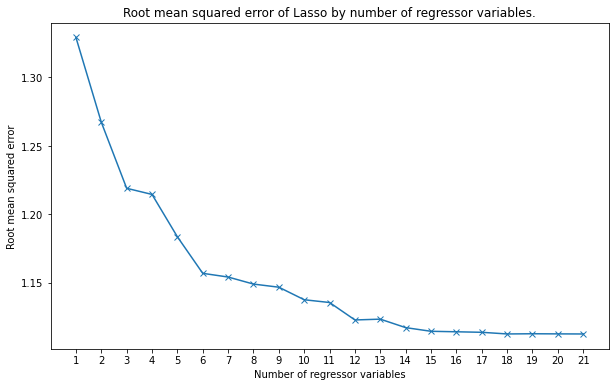

In [50]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(ngrid, lasso_metrics, marker='x')
ax.set_xticks(ngrid)
title = "Root mean squared error of Lasso by number of regressor variables."
ax.set_title(title)
xlabel = "Number of regressor variables"
ylabel = "Root mean squared error"
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
fig.savefig(img_folder + "selection_lasso_num_vars.png")
plt.show()

The previous four procedures(two for Ridge and two for Lasso) provide us with different rankings in decreasing order of importance of each regressor variable.
In order to collectively consider the results of each of these procedures, we apply the following rule:

1. Let $V$ be the set of regressor variables. Initialize $r_v = 0$ for each $v \in V$.

2. For each one of the four rankings $R_i$, let $p_i(v)$ be the position of the regressor variable $v$ in that ranking. Make $r_v \leftarrow r_v + p_i(v)$.

3. Sort the regressor variables in increasing order of $r_v$. This order provides a sequence of regressor variables in decreasing order of importance.

In [51]:
input_cols_sums = {c : 0 for c in input_cols}
for ranking in [ridge_input_ranking, lasso_input_ranking]:
    for j,i in enumerate(ranking):
        c = input_cols[i]
        input_cols_sums[c] += j
        
for rem_ord in [ridge_remove_order, lasso_remove_order]:
    for i, c in enumerate(reversed(rem_ord)):
        input_cols_sums[c] += i

In [52]:
input_ranking = sorted(input_cols, key=lambda x: input_cols_sums[x])

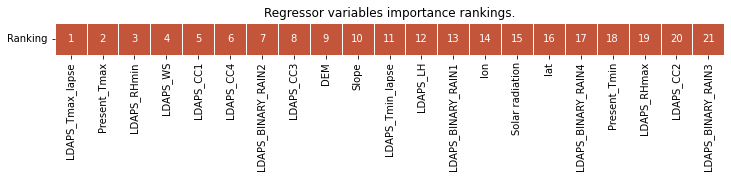

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
col_rankings = np.zeros((1, num_inputs))
for i, c in enumerate(input_ranking):
    col_rankings[0, i] = i + 1
sns.heatmap(col_rankings, ax=ax, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar=False, cbar_kws={"shrink": .5}, annot=True, fmt=".0f",
           yticklabels=['Ranking'], xticklabels=input_ranking)
title = "Regressor variables importance rankings."
ax.set_title(title)
plt.yticks(rotation=0)
fig.savefig(img_folder + "input_ranking.png")
plt.show()

### Principal Component Analysis

Since many of the regressor variables are pairwise significantly correlated, we will also be applying PCA to the numerical regressor variables.

Below we "train" a PCA transformer using the training set. There are $21$ numerical regressor variables and we consider a PCA transformation from $\mathbb{R}^{21} \rightarrow \mathbb{R}^{21}$, hence leading to $21$ projected components. 

In the chart below, for each $i = 1, \ldots, 21$, we display the percentage amount of variance explained by the $i$-th component and we also display the cumulative amount of percentage variance explained by the $j$-th components, for $j \leq i$.

In [54]:
num_pca_comps = len(mut_cols)
train_pca_transformer = sklearn.decomposition.PCA(n_components=num_pca_comps)
train_pca_transformer.fit(X=train_data[mut_cols])
pca_train_data = train_pca_transformer.transform(X=train_data[mut_cols])

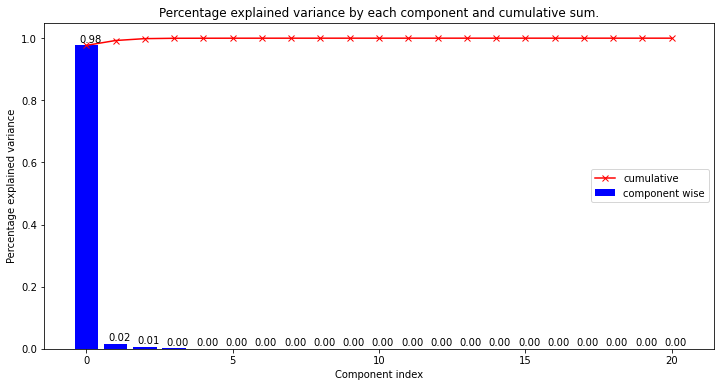

In [55]:
fig, ax = plt.subplots(figsize=(12,6))
comp_exp_var = copy.copy(train_pca_transformer.explained_variance_ratio_)
cum_comp_exp_var = np.cumsum(comp_exp_var)
x = list(range(num_pca_comps))
ax.plot(x, cum_comp_exp_var, color='red', marker='x', label="cumulative")
ax.bar(x, comp_exp_var, color='blue', label="component wise")
for i, v in enumerate(comp_exp_var):
    plt.text(x[i] - 0.25, v + 0.01, "{:.2f}".format(v))
ax.legend(loc='center right')
title = "Percentage explained variance by each component and cumulative sum."
ax.set_title(title)
xlabel = "Component index"
ylabel = "Percentage explained variance"
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
fig.savefig(img_folder + "pca_perc_var.png")
plt.show()

In [56]:
k_fold_pcad_train_data = [None for i in range(k)]
k_fold_pcad_test_data = [None for i in range(k)]
k_fold_pca_transformers = [None for i in range(k)]
for i in range(k):
    tr = k_fold_train_data[i]
    te = k_fold_test_data[i]
    transformer = sklearn.decomposition.PCA(n_components=num_pca_comps)
    transformer.fit(X=tr[mut_cols])
    k_fold_pca_transformers[i] = copy.deepcopy(normalizer)
    k_fold_pcad_train_data[i] = transformer.transform(X=tr[mut_cols])
    k_fold_pcad_test_data[i] = transformer.transform(X=te[mut_cols])

We note from the chart above that the first five principal components found by PCA explain more than $99\%$ of the variance.

### Model Training

We now proceed to model training. 

The exploratory data analysis presented above shows that there are pairs of regressor variables which are significantly correlated.
Moreover, the feature selection procedures presented above assesses the importance of each regressor variable for predicting the target variable. These procedures suggest that some of the regressor variables are not very effective for predicting the target variable.

Taking this into consideration, we shall be considering only $12$ input variables.
We consider the $12$ regressor variables which were considered to be the most relevant based on the analysis performed in the feature selection section.

We begin by training different regression models.
All these models have the next-day maximum temperature as target variables and have as regressor variables the following variables: 'LDAPS_Tmax_lapse', 'Present_Tmax', 'LDAPS_RHmin', 'LDAPS_WS', 'LDAPS_CC4', 'LDAPS_CC3', 'LDAPS_CC1', 'LDAPS_BINARY_RAIN2', 'LDAPS_Tmin_lapse', 'DEM', 'Slope' and 'LDAPS_LH'.

In [57]:
sel_input_cols = input_ranking[:num_sel_inputs]

In [58]:
def RMSE(y_true, y_pred):
    return sklearn.metrics.mean_squared_error(y_true, y_pred, squared=False)

In [59]:
mae_scorer = sklearn.metrics.make_scorer(sklearn.metrics.mean_absolute_error, greater_is_better=False)

In [60]:
metrics = {
    "R^2" : sklearn.metrics.r2_score,
    "Mean Absolute Error" : sklearn.metrics.mean_absolute_error,
    "Root Mean Squared Error": RMSE
        }

In [61]:
model_results = {key : [] for key in metrics.keys()}

###### LDAPS Model

In [62]:
ldaps_res = []
model_name = "LDAPS Forecast"
y_true = selected_data['Next_Tmax']
y_pred = selected_data['LDAPS_Tmax_lapse']
for key, met in metrics.items():
        m = met(y_true, y_pred)
        ldaps_res.append((key, m))

In [63]:
ldaps_res

[('R^2', 0.6464211287399376),
 ('Mean Absolute Error', 1.4462904261228253),
 ('Root Mean Squared Error', 1.8502362971862865)]

In [64]:
model_mets = {m : [] for m in metrics.keys()}
for i in range(k):
    te = k_fold_test_data[i]
    te_target = k_fold_test_target[i]
    y_pred = te['LDAPS_Tmax_lapse']
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "LDAPS Forecast"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

In [65]:
model_results

{'R^2': [['LDAPS Forecast',
   0.5865967612320862,
   0.6368953119492371,
   0.6701685673052798,
   0.028421416083387253]],
 'Mean Absolute Error': [['LDAPS Forecast',
   1.4016170366608085,
   1.4571632750620849,
   1.533506020790861,
   0.04222834757479141]],
 'Root Mean Squared Error': [['LDAPS Forecast',
   1.7704904438888933,
   1.8605854719727166,
   1.9676210215865353,
   0.057101604476371734]]}

###### Linear Regression

In [66]:
model_mets = {m : [] for m in metrics.keys()}
for i in range(k):
    model = sklearn.linear_model.LinearRegression(fit_intercept=True)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[sel_input_cols], y=tr_target)
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Linear Regression"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

###### Ridge Regression

In [67]:
alpha_grid = np.logspace(-4, 2, 200)
num_inputs = len(sel_input_cols)
best_metric = math.inf
ridge_best_alpha = None
for alpha in tqdm(alpha_grid):
    curr_metrics = []
    for i in range(k):
        model = sklearn.linear_model.Ridge(alpha=alpha, fit_intercept=True, random_state=random_state)
        tr = k_fold_normalized_train_data[i]
        te = k_fold_normalized_test_data[i]
        tr_target = k_fold_train_target[i]
        te_target = k_fold_test_target[i]
        model.fit(X=tr[sel_input_cols], y=tr_target)
        y_pred = model.predict(X=te[sel_input_cols])
        m = sklearn.metrics.mean_squared_error(y_true=te_target, y_pred=y_pred, squared=False)
        curr_metrics.append(m)
    m = np.max(curr_metrics)
    if m < best_metric:
        best_metric = m
        ridge_best_alpha = alpha

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 19.57it/s]


In [68]:
model_mets = {m : [] for m in metrics.keys()}
for i in range(k):
    model = sklearn.linear_model.Ridge(alpha=ridge_best_alpha, fit_intercept=True, random_state=random_state)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[sel_input_cols], y=tr_target)
    y_pred = model.predict(X=te[sel_input_cols])
    m = sklearn.metrics.mean_squared_error(y_true=te_target, y_pred=y_pred, squared=False)
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Ridge"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

###### Lasso Regression

In [69]:
alpha_grid = np.logspace(-4, 2, 200)
num_inputs = len(sel_input_cols)
best_metric = math.inf
lasso_best_alpha = None
for alpha in tqdm(alpha_grid):
    curr_metrics = []
    for i in range(k):
        model = sklearn.linear_model.Lasso(alpha=alpha, fit_intercept=True, random_state=random_state)
        tr = k_fold_normalized_train_data[i]
        te = k_fold_normalized_test_data[i]
        tr_target = k_fold_train_target[i]
        te_target = k_fold_test_target[i]
        model.fit(X=tr[sel_input_cols], y=tr_target)
        y_pred = model.predict(X=te[sel_input_cols])
        m = sklearn.metrics.mean_squared_error(y_true=te_target, y_pred=y_pred, squared=False)
        curr_metrics.append(m)
    m = np.max(curr_metrics)
    if m < best_metric:
        best_metric = m
        lasso_best_alpha = alpha

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.39it/s]


In [70]:
model_mets = {m : [] for m in metrics.keys()}
for i in range(k):
    model = sklearn.linear_model.Lasso(alpha=lasso_best_alpha, fit_intercept=True, random_state=random_state)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[sel_input_cols], y=tr_target)
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Lasso"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

###### Neural Networks

In [71]:
def symmLayers(mid):
    x = []
    for i in range(2):
        for j in range(mid):
            k = j if i == 0 else mid - j - 1
            x.append( 12 + int(12 * k) )
    return tuple(i for i in x)

In [72]:
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=symmLayers(5), 
    activation='relu',
    solver='adam',
    tol=1e-4,
    n_iter_no_change=20,
    max_iter=max_iter,
    verbose=verbose,
    random_state=random_state)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[sel_input_cols], y=tr_target)
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Neural Net, act=relu, L=5"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

  0%|                                                                                                                                               | 0/10 [00:00<?, ?it/s]C:\Users\pmkra\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
 10%|█████████████▌                                                                                                                         | 1/10 [00:14<02:10, 14.51s/it]C:\Users\pmkra\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
 20%|███████████████████████████                                                                                                            | 2/10 [00:23<01:31, 11.42s/it]C:\Users\pmkra\anaconda

In [73]:
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=symmLayers(10), 
    activation='relu',
    solver='adam',
    tol=1e-4,
    n_iter_no_change=20,
    max_iter=max_iter,
    verbose=verbose,
    random_state=random_state)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[sel_input_cols], y=tr_target)
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Neural Net, act=relu, L=10"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

  0%|                                                                                                                                               | 0/10 [00:00<?, ?it/s]C:\Users\pmkra\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
 10%|█████████████▌                                                                                                                         | 1/10 [00:35<05:15, 35.10s/it]C:\Users\pmkra\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
 20%|███████████████████████████                                                                                                            | 2/10 [01:09<04:39, 34.95s/it]C:\Users\pmkra\anaconda

In [93]:
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=symmLayers(15), 
    activation='relu',
    solver='adam',
    tol=1e-4,
    n_iter_no_change=20,
    max_iter=max_iter,
    verbose=verbose,
    random_state=random_state)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[sel_input_cols], y=tr_target)
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Neural Net, act=relu, L=30"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

  0%|                                                                                                                                               | 0/10 [00:00<?, ?it/s]C:\Users\pmkra\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
 10%|█████████████▌                                                                                                                         | 1/10 [01:17<11:40, 77.86s/it]C:\Users\pmkra\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
 20%|███████████████████████████                                                                                                            | 2/10 [02:45<11:07, 83.44s/it]C:\Users\pmkra\anaconda

In [75]:
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=symmLayers(10), 
    activation='logistic',
    solver='adam',
    tol=1e-4,
    n_iter_no_change=20,
    max_iter=max_iter,
    verbose=verbose,
    random_state=random_state)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[sel_input_cols], y=tr_target)
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Neural Net, act=logi, L=10"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

  0%|                                                                                                                                               | 0/10 [00:00<?, ?it/s]C:\Users\pmkra\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
 10%|█████████████▌                                                                                                                         | 1/10 [00:42<06:21, 42.37s/it]C:\Users\pmkra\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
 20%|███████████████████████████                                                                                                            | 2/10 [01:24<05:37, 42.18s/it]C:\Users\pmkra\anaconda

###### Decision Tree

In [76]:
max_depth = 5
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.tree.DecisionTreeRegressor(criterion="squared_error", random_state=random_state, max_depth=max_depth)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[sel_input_cols], y=tr_target)
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Decision Tree MSE, d=" + str(max_depth)
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.42it/s]


In [77]:
max_depth = 100
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.tree.DecisionTreeRegressor(criterion="squared_error", random_state=random_state, max_depth=max_depth)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[sel_input_cols], y=tr_target)
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Decision Tree MSE, d=" + str(max_depth)
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.46it/s]


###### Random Forest

In [78]:
max_depth = 5
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.ensemble.RandomForestRegressor(n_estimators=n_trees, criterion="squared_error", verbose=verbose, 
                                                      random_state=random_state, n_jobs=4, max_depth=max_depth)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[sel_input_cols], y=tr_target)
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Random Forest MSE, d=" + str(max_depth)
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]


In [79]:
max_depth = 100
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.ensemble.RandomForestRegressor(n_estimators=n_trees, criterion="squared_error", verbose=verbose, 
                                                      random_state=random_state, n_jobs=4, max_depth=max_depth)
    tr = k_fold_pcad_train_data[i]
    te = k_fold_pcad_test_data[i]
    tr_target = k_fold_train_target[i]
    te_target = k_fold_test_target[i]
    model.fit(X=tr[:, :num_sel_pca_comps], y=tr_target)
    y_pred = model.predict(X=te[:, :num_sel_pca_comps])
    y_true = te_target
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Random Forest MSE, d=" + str(max_depth)
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.54s/it]


###### Gradient Boosting

In [80]:
max_depth = 5
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.ensemble.GradientBoostingRegressor(n_estimators=n_trees, criterion='squared_error', 
                                                       verbose=verbose, random_state=random_state,
                                                      max_depth=max_depth)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    model.fit(X=tr[sel_input_cols], y=tr[target_col])
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te[target_col]
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Gradient Boosting MSE, d=" + str(max_depth)
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it]


In [81]:
max_depth = 100
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.ensemble.GradientBoostingRegressor(n_estimators=n_trees, criterion='squared_error', 
                                                       verbose=verbose, random_state=random_state,
                                                      max_depth=max_depth)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    model.fit(X=tr[sel_input_cols], y=tr[target_col])
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te[target_col]
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "Gradient Boosting MSE, d=" + str(max_depth)
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.39s/it]


###### Support Vector Machine

In [82]:
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.svm.SVR(kernel='linear', verbose=verbose)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    model.fit(X=tr[sel_input_cols], y=tr[target_col])
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te[target_col]
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "SVM, Linear Kernel"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.77s/it]


In [83]:
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.svm.SVR(kernel='rbf', verbose=verbose)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    model.fit(X=tr[sel_input_cols], y=tr[target_col])
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te[target_col]
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "SVM, RBF Kernel"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]


In [84]:
model_mets = {m : [] for m in metrics.keys()}
for i in tqdm(range(k)):
    model = sklearn.svm.SVR(kernel='poly', verbose=verbose)
    tr = k_fold_normalized_train_data[i]
    te = k_fold_normalized_test_data[i]
    model.fit(X=tr[sel_input_cols], y=tr[target_col])
    y_pred = model.predict(X=te[sel_input_cols])
    y_true = te[target_col]
    for key, met in metrics.items():
        m = met(y_true, y_pred)
        model_mets[key].append(m)
model_name = "SVM, Poly Kernel"
for key in metrics.keys():
    mmin = np.min(model_mets[key])
    mmax = np.max(model_mets[key])
    mmean = np.mean(model_mets[key])
    mstd = np.std(model_mets[key])
    model_results[key].append([model_name, mmin, mmean, mmax, mstd])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


### Cross-Validation Results

In [94]:
df_results = {}
for key in metrics.keys():
    df_results[key] = pd.DataFrame(model_results[key], columns=["Model", "Min", "Mean", "Max", "Std"])

In [95]:
tab_folder = "Tables\\"

In [96]:
df_results["R^2"]
df_results["R^2"].to_csv(path_or_buf=tab_folder + "cv_rsqr_results.csv")

In [97]:
df_results["Mean Absolute Error"]
df_results["Mean Absolute Error"].to_csv(path_or_buf=tab_folder + "cv_mae_results.csv")

In [98]:
df_results["Root Mean Squared Error"]
df_results["Root Mean Squared Error"].to_csv(path_or_buf=tab_folder + "cv_rmse_results.csv")

In [99]:
df_results["R^2"]

Model       Min      Mean       Max       Std
0                 LDAPS Forecast  0.586597  0.636895  0.670169  0.028421
1              Linear Regression  0.736030  0.767636  0.791083  0.019272
2                          Ridge  0.737329  0.767218  0.789655  0.018514
3                          Lasso  0.736688  0.766995  0.790564  0.018443
4      Neural Net, act=relu, L=5  0.769261  0.794036  0.810584  0.014704
5     Neural Net, act=relu, L=10  0.741102  0.801764  0.834452  0.027731
6      Neural Net, act=logi, L=5 -1.501970 -1.299200 -1.125108  0.114157
7     Neural Net, act=logi, L=10 -1.306280 -1.123533 -0.968957  0.103036
8         Decision Tree MSE, d=5  0.703413  0.743244  0.768287  0.018868
9       Decision Tree MSE, d=100  0.659511  0.718391  0.757114  0.030280
10        Random Forest MSE, d=5  0.739958  0.774173  0.799146  0.016060
11      Random Forest MSE, d=100  0.807081  0.842000  0.864452  0.019228
12    Gradient Boosting MSE, d=5  0.837051  0.866054  0.888877  0.017197
13  Gradient Boosting MSE, d=100  0.672372  0.741348  0.786221  0.032651
14            SVM, Linear Kernel  0.734269  0.766913  0.790797  0.020311
15               SVM, RBF Kernel  0.792621  0.824872  0.848439  0.019054
16              SVM, Poly Kernel  0.716472  0.758809  0.794020  0.019880
17    Neural Net, act=relu, L=30  0.723711  0.783392  0.831390  0.031060

In [100]:
df_results["Root Mean Squared Error"]

Model       Min      Mean       Max       Std
0                 LDAPS Forecast  1.770490  1.860585  1.967621  0.057102
1              Linear Regression  1.416199  1.488145  1.572287  0.045440
2                          Ridge  1.421031  1.489626  1.568413  0.043583
3                          Lasso  1.417957  1.490360  1.570327  0.043760
4      Neural Net, act=relu, L=5  1.341703  1.401531  1.469994  0.037963
5     Neural Net, act=relu, L=10  1.263102  1.371769  1.514797  0.072772
6      Neural Net, act=logi, L=5  4.569055  4.684173  4.749621  0.048483
7     Neural Net, act=logi, L=10  4.389421  4.501806  4.566876  0.047183
8         Decision Tree MSE, d=5  1.491461  1.564856  1.656728  0.046829
9       Decision Tree MSE, d=100  1.532679  1.637017  1.737167  0.067401
10        Random Forest MSE, d=5  1.388601  1.467759  1.551303  0.046051
11      Random Forest MSE, d=100  1.140732  1.225595  1.336173  0.057599
12    Gradient Boosting MSE, d=5  1.031144  1.128307  1.228009  0.059906
13  Gradient Boosting MSE, d=100  1.466133  1.567919  1.704041  0.078837
14            SVM, Linear Kernel  1.417166  1.490256  1.577523  0.047156
15               SVM, RBF Kernel  1.216436  1.290891  1.385343  0.054116
16              SVM, Poly Kernel  1.429920  1.516452  1.619845  0.055731
17    Neural Net, act=relu, L=30  1.265872  1.435381  1.641184  0.109973

In [91]:
def

SyntaxError: invalid syntax (1102136943.py, line 1)

### Final Models

In [118]:
final_model_results = [] #{key : [] for key in metrics.keys()}

In [119]:
y_pred = test_data['LDAPS_Tmax_lapse']
y_true = test_data['Next_Tmax']
model_mets = {m : 0 for m in metrics.keys()}
for key, mfun in metrics.items():
    m = mfun(y_true, y_pred)
    model_mets[key] = m
final_model_results.append(["LDAPS Forecast"] + [model_mets[key] for key in metrics.keys()])

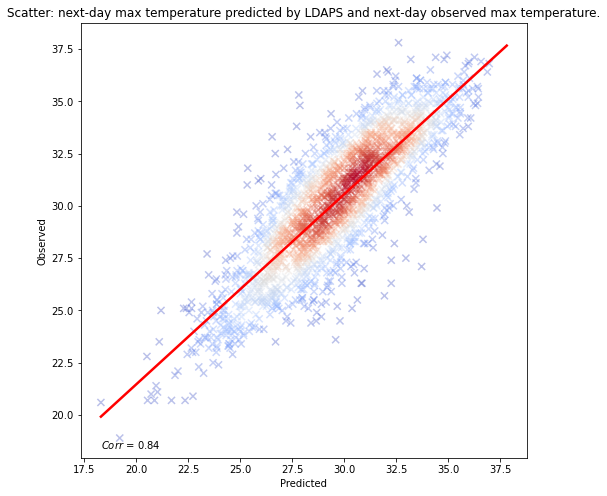

In [120]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
xdata = y_pred
ydata = y_true
xy = np.vstack([xdata,ydata])
z = scipy.stats.gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xdata, ydata, z = xdata[idx], ydata[idx], z[idx]

corr = np.corrcoef(xdata, ydata)[0][1]
coeffs = np.polyfit(xdata, ydata, deg=1)
f_hat = np.poly1d(coeffs)
x_domain = np.linspace(min(xdata), max(ydata), num=1000)
pred_y = f_hat(x_domain)
ax.scatter(xdata, ydata, marker='x', c=z, s=50, alpha=0.35, cmap=cm.coolwarm)
ax.plot(x_domain, pred_y, linestyle='-', color='red', linewidth=2.5)
title = ("Scatter: next-day max temperature predicted by LDAPS and next-day observed max temperature.")
xlabel = "Predicted"
ylabel = "Observed"
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.text(min(xdata), 1.005 * min(xdata), "$Corr $ = " + "{:.2f}".format(corr) )
fig.savefig(img_folder + "scatter_nextmax_pred_ldaps.png")
plt.show()

In [121]:
model = sklearn.svm.SVR(kernel='rbf', verbose=verbose)
max_depth = 5
model_mets = {m : 0 for m in metrics.keys()}
final_svr_model = model = sklearn.svm.SVR(kernel='rbf', verbose=verbose)
tr = normalized_train_data
te = normalized_test_data
tr_target = train_data[target_col]
te_target = test_data[target_col]
final_svr_model.fit(X=tr[sel_input_cols], y=tr_target)
y_pred = final_svr_model.predict(X=te[sel_input_cols])
y_true = te_target
for key, met in metrics.items():
    m = met(y_true, y_pred)
    model_mets[key] = m
final_model_results.append(["SVM, RBF Kernel"] + [model_mets[key] for key in metrics.keys()])

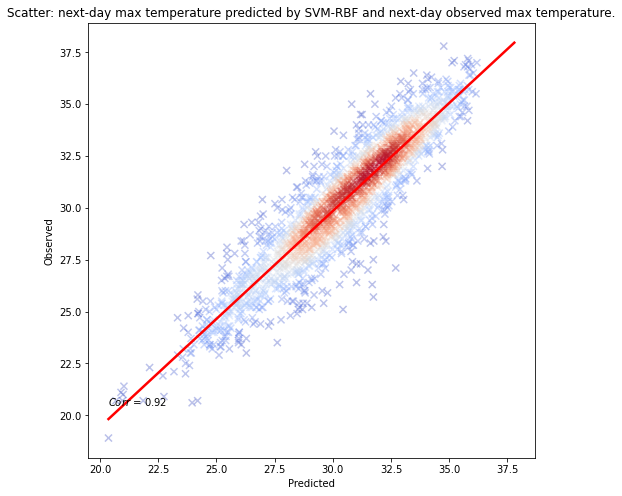

In [122]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
xdata = y_pred
ydata = y_true
xy = np.vstack([xdata,ydata])
z = scipy.stats.gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xdata, ydata, z = xdata[idx], ydata[idx], z[idx]

corr = np.corrcoef(xdata, ydata)[0][1]
coeffs = np.polyfit(xdata, ydata, deg=1)
f_hat = np.poly1d(coeffs)
x_domain = np.linspace(min(xdata), max(ydata), num=1000)
pred_y = f_hat(x_domain)
ax.scatter(xdata, ydata, marker='x', c=z, s=50, alpha=0.35, cmap=cm.coolwarm)
ax.plot(x_domain, pred_y, linestyle='-', color='red', linewidth=2.5)
title = ("Scatter: next-day max temperature predicted by SVM-RBF and next-day observed max temperature.")
xlabel = "Predicted"
ylabel = "Observed"
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.text(min(xdata), 1.005 * min(xdata), "$Corr $ = " + "{:.2f}".format(corr) )
fig.savefig(img_folder + "scatter_nextmax_pred_svm.png")
plt.show()

In [123]:
max_depth = 100
model_mets = {m : 0 for m in metrics.keys()}
final_rf_model = sklearn.ensemble.RandomForestRegressor(n_estimators=n_trees, criterion="squared_error", verbose=verbose, 
                                                      random_state=random_state, n_jobs=4, max_depth=max_depth)
tr = normalized_train_data
te = normalized_test_data
tr_target = train_data[target_col]
te_target = test_data[target_col]
final_rf_model.fit(X=tr[sel_input_cols], y=tr_target)
y_pred = final_rf_model.predict(X=te[sel_input_cols])
y_true = te_target
for key, met in metrics.items():
    m = met(y_true, y_pred)
    model_mets[key] = m
final_model_results.append(["Random Forest, d=100"] + [model_mets[key] for key in metrics.keys()])

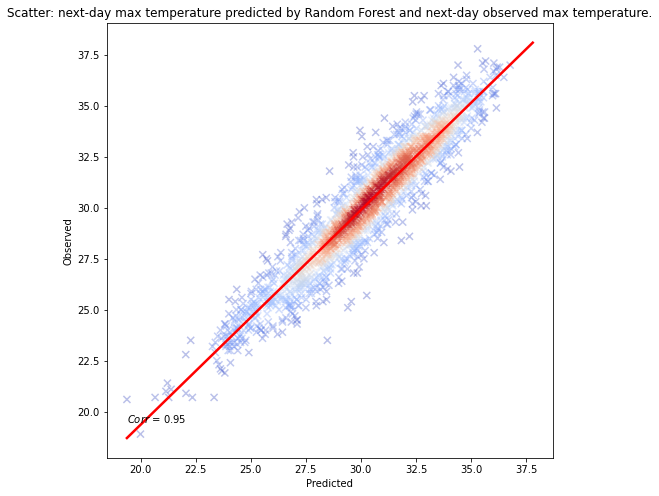

In [124]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
xdata = y_pred
ydata = y_true
xy = np.vstack([xdata,ydata])
z = scipy.stats.gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xdata, ydata, z = xdata[idx], ydata[idx], z[idx]

corr = np.corrcoef(xdata, ydata)[0][1]
coeffs = np.polyfit(xdata, ydata, deg=1)
f_hat = np.poly1d(coeffs)
x_domain = np.linspace(min(xdata), max(ydata), num=1000)
pred_y = f_hat(x_domain)
ax.scatter(xdata, ydata, marker='x', c=z, s=50, alpha=0.35, cmap=cm.coolwarm)
ax.plot(x_domain, pred_y, linestyle='-', color='red', linewidth=2.5)
title = ("Scatter: next-day max temperature predicted by Random Forest and next-day observed max temperature.")
xlabel = "Predicted"
ylabel = "Observed"
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.text(min(xdata), 1.005 * min(xdata), "$Corr $ = " + "{:.2f}".format(corr) )
fig.savefig(img_folder + "scatter_nextmax_pred_rf.png")
plt.show()

In [125]:
max_depth = 5
model_mets = {m : 0 for m in metrics.keys()}
final_gb_model = sklearn.ensemble.GradientBoostingRegressor(n_estimators=n_trees, criterion='squared_error', 
                                                       verbose=verbose, random_state=random_state,
                                                      max_depth=max_depth)
tr = normalized_train_data
te = normalized_test_data
tr_target = train_data[target_col]
te_target = test_data[target_col]
final_gb_model.fit(X=tr[sel_input_cols], y=tr_target)
y_pred = final_gb_model.predict(X=te[sel_input_cols])
y_true = te_target
for key, met in metrics.items():
    m = met(y_true, y_pred)
    model_mets[key] = m
final_model_results.append(["Gradient Boosting, d=5"] + [model_mets[key] for key in metrics.keys()])

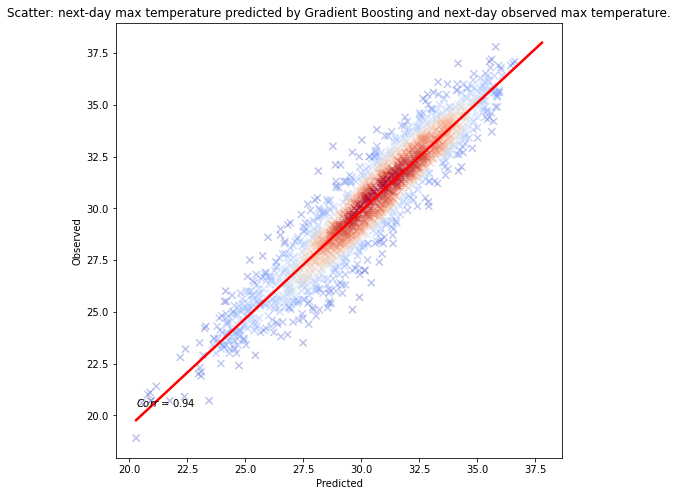

In [126]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
xdata = y_pred
ydata = y_true
xy = np.vstack([xdata,ydata])
z = scipy.stats.gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xdata, ydata, z = xdata[idx], ydata[idx], z[idx]

corr = np.corrcoef(xdata, ydata)[0][1]
coeffs = np.polyfit(xdata, ydata, deg=1)
f_hat = np.poly1d(coeffs)
x_domain = np.linspace(min(xdata), max(ydata), num=1000)
pred_y = f_hat(x_domain)
ax.scatter(xdata, ydata, marker='x', c=z, s=50, alpha=0.35, cmap=cm.coolwarm)
ax.plot(x_domain, pred_y, linestyle='-', color='red', linewidth=2.5)
title = ("Scatter: next-day max temperature predicted by Gradient Boosting and next-day observed max temperature.")
xlabel = "Predicted"
ylabel = "Observed"
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.text(min(xdata), 1.005 * min(xdata), "$Corr $ = " + "{:.2f}".format(corr) )
fig.savefig(img_folder + "scatter_nextmax_pred_gb.png")
plt.show()

In [127]:
model_mets = {m : 0 for m in metrics.keys()}
final_nn_model = sklearn.neural_network.MLPRegressor(
    hidden_layer_sizes=symmLayers(10), 
    activation='relu',
    solver='adam',
    tol=1e-4,
    n_iter_no_change=50,
    max_iter=500,
    verbose=True,
    random_state=random_state)
tr = normalized_train_data
te = normalized_test_data
tr_target = train_data[target_col]
te_target = test_data[target_col]
final_nn_model.fit(X=tr[sel_input_cols], y=tr_target)
y_pred = final_nn_model.predict(X=te[sel_input_cols])
y_true = te_target
for key, met in metrics.items():
    m = met(y_true, y_pred)
    model_mets[key] = m
final_model_results.append(["Neural Network, L=10"] + [model_mets[key] for key in metrics.keys()])

Iteration 1, loss = 389.08016116
Iteration 2, loss = 39.32523765
Iteration 3, loss = 5.50583804
Iteration 4, loss = 2.51600111
Iteration 5, loss = 2.03579640
Iteration 6, loss = 1.84677202
Iteration 7, loss = 1.71211513
Iteration 8, loss = 1.61712567
Iteration 9, loss = 1.53521551
Iteration 10, loss = 1.47226217
Iteration 11, loss = 1.42440850
Iteration 12, loss = 1.37594720
Iteration 13, loss = 1.34847016
Iteration 14, loss = 1.32347396
Iteration 15, loss = 1.28709393
Iteration 16, loss = 1.25268817
Iteration 17, loss = 1.26759735
Iteration 18, loss = 1.25885952
Iteration 19, loss = 1.23274523
Iteration 20, loss = 1.18224587
Iteration 21, loss = 1.16719075
Iteration 22, loss = 1.14419129
Iteration 23, loss = 1.13047470
Iteration 24, loss = 1.13326449
Iteration 25, loss = 1.10746184
Iteration 26, loss = 1.12103385
Iteration 27, loss = 1.11157866
Iteration 28, loss = 1.11360882
Iteration 29, loss = 1.09280174
Iteration 30, loss = 1.12387014
Iteration 31, loss = 1.07395153
Iteration 32, 

Iteration 253, loss = 0.54884575
Iteration 254, loss = 0.50625142
Iteration 255, loss = 0.49961682
Iteration 256, loss = 0.49788942
Iteration 257, loss = 0.50041216
Iteration 258, loss = 0.48081445
Iteration 259, loss = 0.49202782
Iteration 260, loss = 0.52630827
Iteration 261, loss = 0.47419869
Iteration 262, loss = 0.48009489
Iteration 263, loss = 0.45968582
Iteration 264, loss = 0.49514480
Iteration 265, loss = 0.51158459
Iteration 266, loss = 0.51403790
Iteration 267, loss = 0.48786140
Iteration 268, loss = 0.49113026
Iteration 269, loss = 0.60492130
Iteration 270, loss = 0.50743798
Iteration 271, loss = 0.46517013
Iteration 272, loss = 0.49525570
Iteration 273, loss = 0.47968568
Iteration 274, loss = 0.50547381
Iteration 275, loss = 0.49530147
Iteration 276, loss = 0.63652713
Iteration 277, loss = 0.68573410
Iteration 278, loss = 0.59333606
Iteration 279, loss = 0.49569430
Iteration 280, loss = 0.49257522
Iteration 281, loss = 0.44761529
Iteration 282, loss = 0.48083791
Iteration 

C:\Users\pmkra\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


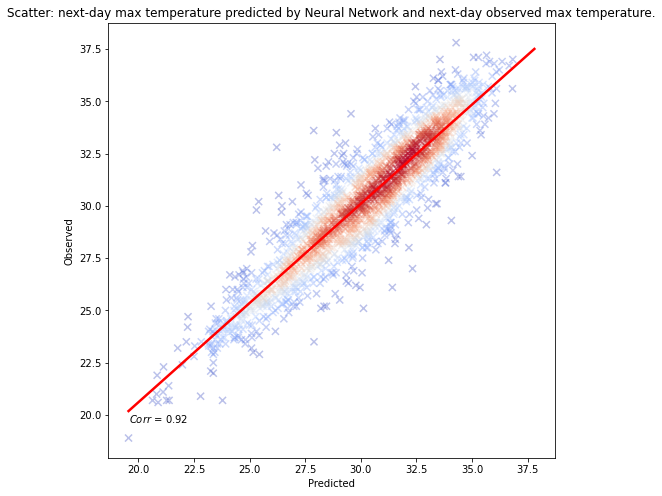

In [128]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
xdata = y_pred
ydata = y_true
xy = np.vstack([xdata,ydata])
z = scipy.stats.gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xdata, ydata, z = xdata[idx], ydata[idx], z[idx]

corr = np.corrcoef(xdata, ydata)[0][1]
coeffs = np.polyfit(xdata, ydata, deg=1)
f_hat = np.poly1d(coeffs)
x_domain = np.linspace(min(xdata), max(ydata), num=1000)
pred_y = f_hat(x_domain)
ax.scatter(xdata, ydata, marker='x', c=z, s=50, alpha=0.35, cmap=cm.coolwarm)
ax.plot(x_domain, pred_y, linestyle='-', color='red', linewidth=2.5)
title = ("Scatter: next-day max temperature predicted by Neural Network and next-day observed max temperature.")
xlabel = "Predicted"
ylabel = "Observed"
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.text(min(xdata), 1.005 * min(xdata), "$Corr $ = " + "{:.2f}".format(corr) )
fig.savefig(img_folder + "scatter_nextmax_pred_nn.png")
plt.show()

In [129]:
final_results = pd.DataFrame(final_model_results, columns=["Model", "R^2", "Mean Absolute Error", "Root Mean Squared Error"])
final_results.to_csv(path_or_buf=tab_folder + "final_results.csv")

In [130]:
final_results

Model       R^2  Mean Absolute Error  \
0          LDAPS Forecast  0.670369             1.413657   
1         SVM, RBF Kernel  0.842250             0.953885   
2      Random Forest, d=5  0.892661             0.792284   
3  Gradient Boosting, d=5  0.882138             0.842596   
4    Neural Network, L=10  0.842420             0.945595   

   Root Mean Squared Error  
0                 1.816134  
1                 1.256375  
2                 1.036366  
3                 1.085978  
4                 1.255695